# Capstone Project - The Battle of Neighborhoods

## 1. Prepocessing

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

%matplotlib inline

*Define Foursquare Credentials and Version*

In [2]:
CLIENT_ID = "EBHQ1RY4QOLUNPZ11KRPAZLQIRSXFOUOGSLZGWWTN354JFUU" 
CLIENT_SECRET = "ZFWVCYME3KFCV2KXEWCDUWYCMVR0JGJFXXGWOJDJPL00GLKC" 
VERSION = "20200120"

print("Your credentails:")
print("CLIENT_ID: " + CLIENT_ID)
print("CLIENT_SECRET:" + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EBHQ1RY4QOLUNPZ11KRPAZLQIRSXFOUOGSLZGWWTN354JFUU
CLIENT_SECRET:ZFWVCYME3KFCV2KXEWCDUWYCMVR0JGJFXXGWOJDJPL00GLKC


*Functions will be used to get info*

In [3]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

*Get the data we need*

In [4]:
new_york_data = get_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 2. Analysis

*Conduct an initial analysis by using bar plot.*

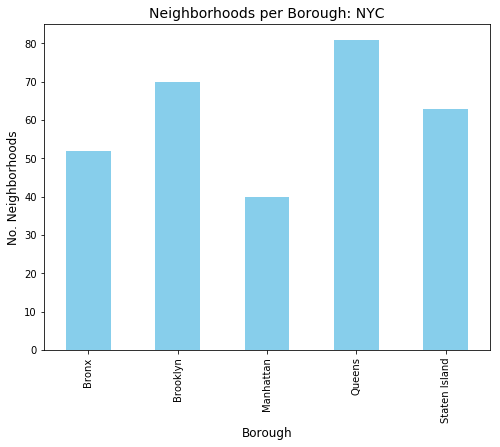

In [5]:
new_york_data.groupby("Borough")["Neighborhood"].count().plot.bar(figsize=(8,6), color = "skyblue")
plt.title("Neighborhoods per Borough: NYC", fontsize = 14)
plt.xlabel("Borough", fontsize = 12)
plt.ylabel("No. Neighborhoods", fontsize = 12)
plt.show()

In [6]:
column_names = ['Borough', 'Neighborhood', 'ID', 'Name']
asian_rest_ny = pd.DataFrame(columns=column_names)
count = 1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    asian_resturants = venues[venues['Category']=='Asian Restaurant']
    print(row)
    for resturant_detail in asian_resturants.values.tolist():
        id, name , category=resturant_detail
        asian_rest_ny = asian_rest_ny.append({'Borough': Borough,
                                              'Neighborhood': Neighborhood, 
                                              'ID': id,
                                              'Name' : name
                                              }, ignore_index=True)
    count+=1

['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
['Bronx', 'Norwood', 40.87722415599446, -73.8793907395681]
['Bronx', 'Williamsbridge', 40.88103887819211, -73.85744642974207]
['Bronx', 'Baychester', 40.866858107252696, -73.83579759808117]
['Bronx', 'Pelham Parkway', 40.85741349808865, -73.85475564017999]
['Bronx', 'City Island', 40.84724670491813, -73.78648845267413]
['Bronx', 'Bedford Park', 40.870185164975325, -73.8855121841913]
['Bronx', 'University Heights', 40.85572707719664, -73.9104159619131]
['Bronx', 'Morris Heights', 40.847897926

['Manhattan', 'West Village', 40.73443393572434, -74.00617998126812]
['Manhattan', 'Manhattan Valley', 40.797307041702865, -73.96428617740655]
['Manhattan', 'Morningside Heights', 40.807999738165826, -73.96389627905332]
['Manhattan', 'Gramercy', 40.737209832715, -73.98137594833541]
['Manhattan', 'Battery Park City', 40.71193198394565, -74.01686930508617]
['Manhattan', 'Financial District', 40.70710710727048, -74.0106654452127]
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321

['Staten Island', 'Chelsea', 40.59472602746295, -74.1895604551969]
['Staten Island', 'Bloomfield', 40.60577868452358, -74.18725638381567]
['Staten Island', 'Bulls Head', 40.6095918004203, -74.15940948657122]
['Manhattan', 'Carnegie Hill', 40.7826825671257, -73.95325646837112]
['Manhattan', 'Noho', 40.72325901885768, -73.98843368023597]
['Manhattan', 'Civic Center', 40.71522892046282, -74.00541529873355]
['Manhattan', 'Midtown South', 40.7485096643122, -73.98871313285247]
['Staten Island', 'Richmond Town', 40.56960594275505, -74.1340572986257]
['Staten Island', 'Shore Acres', 40.60971934079284, -74.06667766061771]
['Staten Island', 'Clifton', 40.61917845202843, -74.072642445484]
['Staten Island', 'Concord', 40.6044731896879, -74.08402364740358]
['Staten Island', 'Emerson Hill', 40.606794394801, -74.09776206972522]
['Staten Island', 'Randall Manor', 40.63563000681151, -74.09805062373887]
['Staten Island', 'Howland Hook', 40.63843283794795, -74.18622331749823]
['Staten Island', 'Elm Park'

In [7]:
asian_rest_ny.to_csv("asian_rest.csv")
asian_rest = pd.read_csv("asian_rest.csv")
asian_rest.drop(columns="Unnamed: 0", inplace=True)
asian_rest.head()

,Borough,Neighborhood,ID,Name
0,Bronx,High Bridge,4c3d29b3a97bbe9a6998fbdd,Happy Garden
1,Bronx,Parkchester,4c472be3972c0f4711ec2221,Neerob
2,Bronx,Pelham Bay,4c1a6b7ab9f876b0dca17846,Shangri-La
3,Brooklyn,Bay Ridge,4ec960ac9adf9c7bf54a9757,Golden Dragon
4,Brooklyn,Brooklyn Heights,5330e34e498e36f70456a24b,Saketumi Asian Bistro


In [8]:
asian_rest.shape

(43, 4)

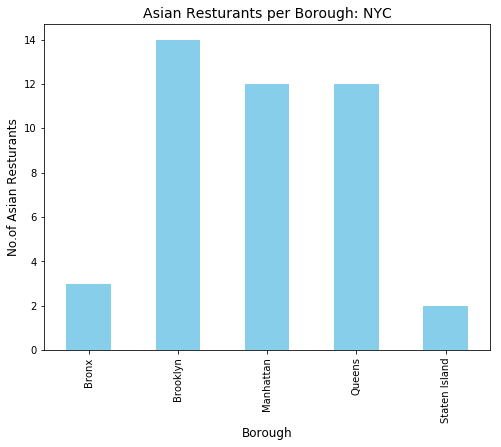

In [9]:
asian_rest.groupby('Borough')['ID'].count().plot.bar(figsize=(8,6), color = "skyblue")
plt.title('Asian Resturants per Borough: NYC', fontsize = 14)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No.of Asian Resturants', fontsize=12)
plt.show()

*From the result we can see that "Brooklyn", "Manhattan", and "Queens" have higher numbers of Asian Resturants per Borough*

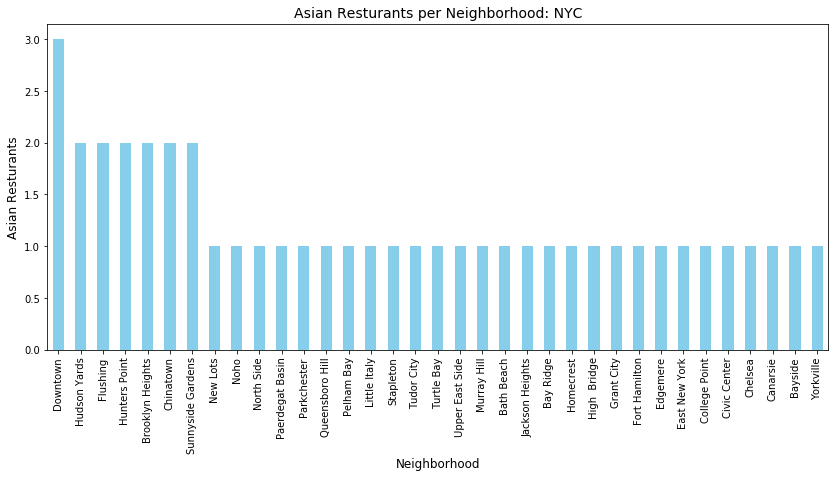

In [10]:
number_of_neigh = 38
asian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(number_of_neigh).plot.bar(figsize=(14,6), color="skyblue")
plt.title('Asian Resturants per Neighborhood: NYC', fontsize = 14)
plt.xlabel('Neighborhood', fontsize = 12)
plt.ylabel('Asian Resturants', fontsize = 12)
plt.show()

*However, due to the results shown as above, I decide not to dig into specific Borough or Neighborood, just regard "New York" as a whole*

*Now we focus on restaurants status*

In [11]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
asian_rest_status=pd.DataFrame(columns=column_names)
count=1
for row in asian_rest.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue(ID)
        print(venue_details)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id = ',ID)
        id,name,likes,rating,tips = [0]*5
    asian_rest_status = asian_rest_status.append({'Borough': Borough,
                                                  'Neighborhood': Neighborhood, 
                                                  'ID': id,
                                                  'Name' : name,
                                                  'Likes' : likes,
                                                  'Rating' : rating,
                                                  'Tips' : tips
                                                  }, ignore_index = True)
    count+=1
asian_rest_status.head()

{'meta': {'code': 200, 'requestId': '5e43008a1a4b0a001b320c64'}, 'response': {'venue': {'id': '4c3d29b3a97bbe9a6998fbdd', 'name': 'Happy Garden', 'contact': {'phone': '7185389042', 'formattedPhone': '(718) 538-9042'}, 'location': {'address': '1150 Ogden Ave', 'lat': 40.836523, 'lng': -73.927094, 'labeledLatLngs': [{'label': 'display', 'lat': 40.836523, 'lng': -73.927094}], 'postalCode': '10452', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1150 Ogden Ave', 'Bronx, NY 10452', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-garden/4c3d29b3a97bbe9a6998fbdd', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese',

{'meta': {'code': 200, 'requestId': '5e43000fb1cac0001bf78f98'}, 'response': {'venue': {'id': '4c1a6b7ab9f876b0dca17846', 'name': 'Shangri-La', 'contact': {'phone': '7188286080', 'formattedPhone': '(718) 828-6080'}, 'location': {'address': '2893-95 Buhre Ave', 'crossStreet': 'Crosby Ave', 'lat': 40.84715972410305, 'lng': -73.83264181934335, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84715972410305, 'lng': -73.83264181934335}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2893-95 Buhre Ave (Crosby Ave)', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shangrila/4c1a6b7ab9f876b0dca17846', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi 

{'meta': {'code': 200, 'requestId': '5e42fecf02a172001b07e083'}, 'response': {'venue': {'id': '5330e34e498e36f70456a24b', 'name': 'Saketumi Asian Bistro', 'contact': {'phone': '7188558688', 'formattedPhone': '(718) 855-8688', 'twitter': 'saketuminyc'}, 'location': {'address': '118 Montague St', 'lat': 40.694909513391174, 'lng': -73.99457785175119, 'labeledLatLngs': [{'label': 'display', 'lat': 40.694909513391174, 'lng': -73.99457785175119}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['118 Montague St', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/saketumi-asian-bistro/5330e34e498e36f70456a24b', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount'

{'meta': {'code': 200, 'requestId': '5e430027edbcad001b983068'}, 'response': {'venue': {'id': '4ba7fa26f964a5208cc339e3', 'name': 'Ozu Japanese Cuisine & Lounge', 'contact': {'phone': '7187973288', 'formattedPhone': '(718) 797-3288', 'twitter': 'ozu78'}, 'location': {'address': '78 Clark St', 'crossStreet': 'btw Henry & Hicks', 'lat': 40.697513, 'lng': -73.993369, 'labeledLatLngs': [{'label': 'display', 'lat': 40.697513, 'lng': -73.993369}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['78 Clark St (btw Henry & Hicks)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ozu-japanese-cuisine--lounge/4ba7fa26f964a5208cc339e3', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8

{'meta': {'code': 200, 'requestId': '5e43005847b43d0024622d49'}, 'response': {'venue': {'id': '4ca55900931bb60c6f8489e2', 'name': 'Golden China', 'contact': {}, 'location': {'address': '1013 Sutter Ave', 'lat': 40.67139597361685, 'lng': -73.88142074252401, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67139597361685, 'lng': -73.88142074252401}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1013 Sutter Ave', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-china/4ca55900931bb60c6f8489e2', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 1, 'groups': [{

{'meta': {'code': 200, 'requestId': '5e4300191e152c001b3cc30b'}, 'response': {'venue': {'id': '4bbbe51d51b89c7493e4862a', 'name': 'Kung Fu Restaurant', 'contact': {'phone': '7182654488', 'formattedPhone': '(718) 265-4488'}, 'location': {'address': '1950 Bath Ave', 'crossStreet': 'at Bay 23rd St', 'lat': 40.60178974142826, 'lng': -74.00229706990487, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60178974142826, 'lng': -74.00229706990487}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1950 Bath Ave (at Bay 23rd St)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kung-fu-restaurant/4bbbe51d51b89c7493e4862a', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5e42ff4d29ce6a001cab7f95'}, 'response': {'venue': {'id': '581e530bfb482d7efaa6a7b8', 'name': 'The Wei', 'contact': {'phone': '7182608888', 'formattedPhone': '(718) 260-8888'}, 'location': {'address': '30 Dekalb Ave', 'crossStreet': 'Flatbush Avenue', 'lat': 40.689856633127924, 'lng': -73.98171689592083, 'labeledLatLngs': [{'label': 'display', 'lat': 40.689856633127924, 'lng': -73.98171689592083}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['30 Dekalb Ave (Flatbush Avenue)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-wei/581e530bfb482d7efaa6a7b8', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 21}

{'meta': {'code': 200, 'requestId': '5e43001d14a126001bb67f64'}, 'response': {'venue': {'id': '429ba900f964a5209d241fe3', 'name': 'Snacky', 'contact': {'phone': '7184864848', 'formattedPhone': '(718) 486-4848'}, 'location': {'address': '187 Grand St', 'crossStreet': 'btwn Bedford Ave. and Driggs Ave.', 'lat': 40.71431800559917, 'lng': -73.96084674536871, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71431800559917, 'lng': -73.96084674536871}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['187 Grand St (btwn Bedford Ave. and Driggs Ave.)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/snacky/429ba900f964a5209d241fe3', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd

{'meta': {'code': 200, 'requestId': '5e43000f69babe001be913e3'}, 'response': {'venue': {'id': '4b89ac72f964a520e94a32e3', 'name': 'Ling Kee', 'contact': {}, 'location': {'address': '42 Canal St', 'crossStreet': 'Ludlow', 'lat': 40.714713, 'lng': -73.991538, 'labeledLatLngs': [{'label': 'display', 'lat': 40.714713, 'lng': -73.991538}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42 Canal St (Ludlow)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ling-kee/4b89ac72f964a520e94a32e3', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '56aa371be4b08b9a8d57350b', 'name': 'Food Stand', 'pluralName': 'Food Stands', 'shortName': 'Food Stand', 'icon': {'prefix': 'https://ss3.4sqi.net/im

{'meta': {'code': 200, 'requestId': '5e43005a9fcb92001b02754a'}, 'response': {'venue': {'id': '5ad77639f0ca956ca022734e', 'name': 'Mighty Bowl', 'contact': {}, 'location': {'address': '1109 Lexington Ave', 'lat': 40.773871676858654, 'lng': -73.95968592966776, 'labeledLatLngs': [{'label': 'display', 'lat': 40.773871676858654, 'lng': -73.95968592966776}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1109 Lexington Ave', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mighty-bowl/5ad77639f0ca956ca022734e', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1bd941735', 'name': 'Salad Place', 'pluralName': 'Salad Places', 'shortName': 'Salad', 'icon': {'prefix': 'https:

{'meta': {'code': 200, 'requestId': '5e42ff90006dce001b869a2b'}, 'response': {'venue': {'id': '579fb23f498e7f9f1b7bd04c', 'name': "Peng's Noodle Folk", 'contact': {'phone': '2123482878', 'formattedPhone': '(212) 348-2878', 'twitter': 'pengnoodle'}, 'location': {'address': '1659 1st Ave', 'crossStreet': 'btwn E 86th & E 87th St', 'lat': 40.77725764842952, 'lng': -73.94911007213871, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77725764842952, 'lng': -73.94911007213871}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1659 1st Ave (btwn E 86th & E 87th St)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pengs-noodle-folk/579fb23f498e7f9f1b7bd04c', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5e42ff6f40a7ea001bdbc08e'}, 'response': {'venue': {'id': '4a75edcff964a520b3e11fe3', 'name': 'Wild Ginger Vegetarian Kitchen', 'contact': {'phone': '2129661883', 'formattedPhone': '(212) 966-1883', 'twitter': 'wildgingerveg'}, 'location': {'address': '380 Broome St', 'crossStreet': 'at Mulberry St.', 'lat': 40.7204313711967, 'lng': -73.99663971306008, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7204313711967, 'lng': -73.99663971306008}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['380 Broome St (at Mulberry St.)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wild-ginger-vegetarian-kitchen/4a75edcff964a520b3e11fe3', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '5e4300060cc1fd001b9fb336'}, 'response': {'venue': {'id': '538fa0b1498e0368466178f3', 'name': 'Saw Shack', 'contact': {'phone': '7188982768', 'formattedPhone': '(718) 898-2768', 'twitter': 'sawshack'}, 'location': {'address': '84-22 84th Ave', 'lat': 40.750008818255026, 'lng': -73.88186659989665, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750008818255026, 'lng': -73.88186659989665}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['84-22 84th Ave', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/saw-shack/538fa0b1498e0368466178f3', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 4}, 'url': 'h

{'meta': {'code': 200, 'requestId': '5e43001d6d8c56001b6083f3'}, 'response': {'venue': {'id': '4cdb41696ad1a093c02ceb56', 'name': 'Canaan Restaurant', 'contact': {'phone': '7188868844', 'formattedPhone': '(718) 886-8844'}, 'location': {'address': '1456 College Point Blvd', 'lat': 40.78444163538903, 'lng': -73.8458165938532, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78444163538903, 'lng': -73.8458165938532}], 'postalCode': '11356', 'cc': 'US', 'city': 'College Point', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1456 College Point Blvd', 'College Point, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/canaan-restaurant/4cdb41696ad1a093c02ceb56', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'pric

{'meta': {'code': 200, 'requestId': '5e42ffab71c428001b1a98c1'}, 'response': {'venue': {'id': '4e4e41d9bd4101d0d7a61f1d', 'name': 'New Garden Restaurant', 'contact': {'phone': '7183376015', 'formattedPhone': '(718) 337-6015'}, 'location': {'address': '4317 Beach Channel Dr', 'lat': 40.595515999999996, 'lng': -73.775436, 'labeledLatLngs': [{'label': 'display', 'lat': 40.595515999999996, 'lng': -73.775436}], 'postalCode': '11691', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4317 Beach Channel Dr', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-garden-restaurant/4e4e41d9bd4101d0d7a61f1d', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier

{'meta': {'code': 200, 'requestId': '5e42ff9e95feaf001b99a74b'}, 'response': {'venue': {'id': '4dc5e9c3887717c88030d15c', 'name': 'Bay House Bistro', 'contact': {'phone': '7185560480', 'formattedPhone': '(718) 556-0480'}, 'location': {'address': '574 Bay St', 'lat': 40.62782715401129, 'lng': -74.07624426687075, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62782715401129, 'lng': -74.07624426687075}], 'postalCode': '10304', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['574 Bay St', 'Staten Island, NY 10304', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bay-house-bistro/4dc5e9c3887717c88030d15c', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName'

{'meta': {'code': 200, 'requestId': '5e42ffad1835dd001ba13444'}, 'response': {'venue': {'id': '5738dace498ed8ebd77275f4', 'name': 'Simple Asia', 'contact': {}, 'location': {'address': '2333 Hylan Blvd', 'crossStreet': 'Bancroft Ave', 'lat': 40.57429, 'lng': -74.1064, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57429, 'lng': -74.1064}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2333 Hylan Blvd (Bancroft Ave)', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/simple-asia/5738dace498ed8ebd77275f4', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count':

{'meta': {'code': 200, 'requestId': '5e42ff13dd0f8500294046d9'}, 'response': {'venue': {'id': '51df85c9498edb5ea3ad2e2a', 'name': 'Khe-Yo', 'contact': {'phone': '2125871089', 'formattedPhone': '(212) 587-1089', 'twitter': 'khe_yo', 'instagram': 'khe_yo'}, 'location': {'address': '157 Duane Street', 'crossStreet': 'btwn Hudson St & W Broadway', 'lat': 40.716752816876635, 'lng': -74.00858376295221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.716752816876635, 'lng': -74.00858376295221}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['157 Duane Street (btwn Hudson St & W Broadway)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kheyo/51df85c9498edb5ea3ad2e2a', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '

{'meta': {'code': 200, 'requestId': '5e42ff5229ce6a001cab966d'}, 'response': {'venue': {'id': '4bf49b526a31d13a0608962e', 'name': 'Double Dragon Chinese Food', 'contact': {'phone': '7182098070', 'formattedPhone': '(718) 209-8070'}, 'location': {'address': '8712 Avenue L', 'crossStreet': 'E 87th Street', 'lat': 40.633959000000004, 'lng': -73.902186, 'labeledLatLngs': [{'label': 'display', 'lat': 40.633959000000004, 'lng': -73.902186}], 'postalCode': '11236', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8712 Avenue L (E 87th Street)', 'Brooklyn, NY 11236', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/double-dragon-chinese-food/4bf49b526a31d13a0608962e', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '5e43004c6001fe001b465931'}, 'response': {'venue': {'id': '4b47eb5cf964a520f54326e3', 'name': 'SHI', 'contact': {'phone': '3475376460', 'formattedPhone': '(347) 537-6460'}, 'location': {'address': '4720 Center Blvd', 'crossStreet': 'at 47th Ave.', 'lat': 40.74601152624443, 'lng': -73.95700753754905, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74601152624443, 'lng': -73.95700753754905}], 'postalCode': '11109', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4720 Center Blvd (at 47th Ave.)', 'Long Island City, NY 11109', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shi/4b47eb5cf964a520f54326e3', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d11e941735', 'name': 'Cockt

{'meta': {'code': 200, 'requestId': '5e430057f7706a001b3feed4'}, 'response': {'venue': {'id': '540b8829498ef527c96a6973', 'name': 'Sachi Asian Bistro', 'contact': {'phone': '2122971883', 'formattedPhone': '(212) 297-1883', 'twitter': 'sachinewyork', 'facebookUsername': 'sachinewyork', 'facebookName': 'Sachi Asian Bistro NY'}, 'location': {'address': '713 2nd Ave', 'crossStreet': 'btwn E 38th & E 39th St', 'lat': 40.74758733811173, 'lng': -73.9738713063176, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74758733811173, 'lng': -73.9738713063176}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['713 2nd Ave (btwn E 38th & E 39th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/sachinewyork', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

{'meta': {'code': 200, 'requestId': '5e42ffac211536001bfb9704'}, 'response': {'venue': {'id': '53fb82f0498e0e417fe4ccdd', 'name': 'Tibetan Dumpling Cafe', 'contact': {'phone': '3475071555', 'formattedPhone': '(347) 507-1555'}, 'location': {'address': '4908 Queens Blvd', 'lat': 40.74276036790294, 'lng': -73.91557564847503, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74276036790294, 'lng': -73.91557564847503}], 'postalCode': '11377', 'cc': 'US', 'neighborhood': 'Sunnyside', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4908 Queens Blvd', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tibetan-dumpling-cafe/53fb82f0498e0e417fe4ccdd', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCo

{'meta': {'code': 200, 'requestId': '5e430057f7706a001b3ff1e2'}, 'response': {'venue': {'id': '52d873be498e14a2bf838f0c', 'name': 'Fuciaana Asian Food & Crystal Grill', 'contact': {'phone': '6466937049', 'formattedPhone': '(646) 693-7049'}, 'location': {'address': '2478 Coney Island Ave', 'crossStreet': 'at Ave V', 'lat': 40.59637402417453, 'lng': -73.96109823704106, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59637402417453, 'lng': -73.96109823704106}], 'postalCode': '11223', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2478 Coney Island Ave (at Ave V)', 'Brooklyn, NY 11223', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fuciaana-asian-food--crystal-grill/52d873be498e14a2bf838f0c', 'categories': [{'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 'pluralName': 'Asian Restaurants', 'shortName': 'Asian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,High Bridge,0,0,0,0,0
1,Bronx,Parkchester,4c472be3972c0f4711ec2221,Neerob,21,7.1,15
2,Bronx,Pelham Bay,4c1a6b7ab9f876b0dca17846,Shangri-La,35,8.1,20
3,Brooklyn,Bay Ridge,0,0,0,0,0
4,Brooklyn,Brooklyn Heights,5330e34e498e36f70456a24b,Saketumi Asian Bistro,30,7.8,6


In [12]:
asian_rest_status.to_csv('asian_rest_status.csv')

In [13]:
asian_rest_status

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,High Bridge,0,0,0,0,0
1,Bronx,Parkchester,4c472be3972c0f4711ec2221,Neerob,21,7.1,15
2,Bronx,Pelham Bay,4c1a6b7ab9f876b0dca17846,Shangri-La,35,8.1,20
3,Brooklyn,Bay Ridge,0,0,0,0,0
4,Brooklyn,Brooklyn Heights,5330e34e498e36f70456a24b,Saketumi Asian Bistro,30,7.8,6
5,Brooklyn,Brooklyn Heights,4ba7fa26f964a5208cc339e3,Ozu Japanese Cuisine & Lounge,48,7.1,46
6,Brooklyn,East New York,0,0,0,0,0
7,Brooklyn,Canarsie,0,0,0,0,0
8,Brooklyn,Bath Beach,4bbbe51d51b89c7493e4862a,Kung Fu Restaurant,5,5.7,5
9,Brooklyn,Downtown,594481a44c954c4ff51fa46b,Bunsmith,36,7.7,6


*Notice that there are several rows with "0", we need to remove these records*

In [14]:
asian_rest_status = asian_rest_status[asian_rest_status["Rating"] != 0]
asian_rest_status.reset_index(inplace=True)
asian_rest_status.drop("index", axis = 1, inplace = True)

D:\Python\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
asian_rest_status

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Parkchester,4c472be3972c0f4711ec2221,Neerob,21,7.1,15
1,Bronx,Pelham Bay,4c1a6b7ab9f876b0dca17846,Shangri-La,35,8.1,20
2,Brooklyn,Brooklyn Heights,5330e34e498e36f70456a24b,Saketumi Asian Bistro,30,7.8,6
3,Brooklyn,Brooklyn Heights,4ba7fa26f964a5208cc339e3,Ozu Japanese Cuisine & Lounge,48,7.1,46
4,Brooklyn,Bath Beach,4bbbe51d51b89c7493e4862a,Kung Fu Restaurant,5,5.7,5
5,Brooklyn,Downtown,594481a44c954c4ff51fa46b,Bunsmith,36,7.7,6
6,Brooklyn,Downtown,581e530bfb482d7efaa6a7b8,The Wei,44,7.2,21
7,Brooklyn,Downtown,5a87210eda5ede7ae86f82c6,Korilla BBQ,29,7.9,5
8,Brooklyn,North Side,429ba900f964a5209d241fe3,Snacky,175,8.2,64
9,Brooklyn,Fort Hamilton,4c49b9d83013a59369d722e3,Win Hing Chinese Cuisine,3,6.4,5


In [16]:
asian_rest_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
Borough         36 non-null object
Neighborhood    36 non-null object
ID              36 non-null object
Name            36 non-null object
Likes           36 non-null object
Rating          36 non-null object
Tips            36 non-null object
dtypes: object(7)
memory usage: 2.1+ KB


In [17]:
asian_rest_status.groupby("Borough")["ID"].nunique()

Borough
Bronx             2
Brooklyn          9
Manhattan        12
Queens           11
Staten Island     2
Name: ID, dtype: int64

*In order to deal with "Rating", "Tips", and "Likes", we need to change the data type*

In [18]:
asian_rest_status['Likes']=asian_rest_status['Likes'].astype('float64')
asian_rest_status['Tips']=asian_rest_status['Tips'].astype('float64')
asian_rest_status['Rating']=asian_rest_status['Rating'].astype('float64')
asian_rest_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
Borough         36 non-null object
Neighborhood    36 non-null object
ID              36 non-null object
Name            36 non-null object
Likes           36 non-null float64
Rating          36 non-null float64
Tips            36 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.1+ KB


D:\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [19]:
asian_rest_status.describe()

,Likes,Rating,Tips
count,36.000000,36.000000,36.000000
mean,83.111111,7.550000,26.222222
std,194.497709,0.829285,41.845369
min,3.000000,5.700000,1.000000
25%,10.000000,7.100000,4.750000
50%,26.500000,7.700000,8.000000
75%,60.500000,8.125000,21.000000
max,1119.000000,9.100000,185.000000


*Using group by to get the average ratings of every neighborhood*

In [20]:
asian_neighborhood_status = asian_rest_status.groupby('Neighborhood',as_index = False).mean()[['Neighborhood','Rating']]
asian_neighborhood_status.columns = ['Neighborhood','Average Rating']
asian_neighborhood_status.sort_values(['Average Rating'],ascending = False).head()

,Neighborhood,Average Rating
5,Civic Center,8.80
4,Chinatown,8.75
17,Noho,8.70
3,Chelsea,8.70
27,Yorkville,8.40


*Using group by to get the average ratings of every borough*

In [21]:
asian_borough_status=asian_rest_status.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
asian_borough_status.columns=['Borough','Average Rating']
asian_borough_status.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.191667
0,Bronx,7.600000
4,Staten Island,7.300000
1,Brooklyn,7.222222
3,Queens,7.154545


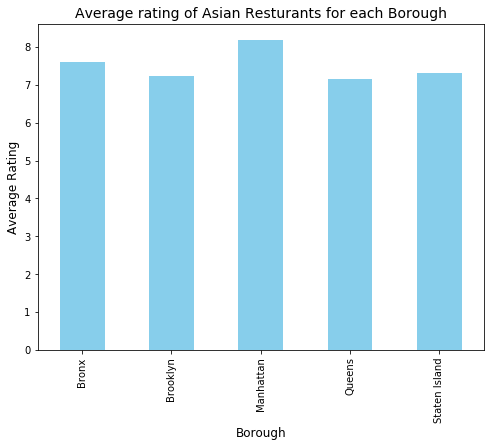

In [22]:
asian_rest_status.groupby('Borough').mean()['Rating'].plot.bar(figsize=(8,6), color="skyblue")
plt.title('Average rating of Asian Resturants for each Borough', fontsize = 14)
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('Average Rating', fontsize = 12)
plt.show()

In [23]:
asian_neighborhood_status_750 = asian_neighborhood_status[asian_neighborhood_status['Average Rating']>=7.5]
asian_neighborhood_status_750.reset_index(inplace=True)
asian_neighborhood_status_750.drop(columns="index", inplace=True)
asian_neighborhood_status_750

D:\Python\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighborhood,Average Rating
0,Chelsea,8.70
1,Chinatown,8.75
2,Civic Center,8.80
3,College Point,7.70
4,Downtown,7.60
5,Hunters Point,7.65
6,Little Italy,8.40
7,Noho,8.70
8,North Side,8.20
9,Pelham Bay,8.10


*My merging result is very interesting that "Chelsea" is merged to both "Manhattan" & "Staten Island". So I have to do another step of cleaning *

In [24]:
asian_merge=pd.merge(asian_neighborhood_status_750, new_york_data, on='Neighborhood')
asian_merge=asian_merge[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
asian_merge

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,8.70
1,Staten Island,Chelsea,40.594726,-74.189560,8.70
2,Manhattan,Chinatown,40.715618,-73.994279,8.75
3,Manhattan,Civic Center,40.715229,-74.005415,8.80
4,Queens,College Point,40.784903,-73.843045,7.70
5,Brooklyn,Downtown,40.690844,-73.983463,7.60
6,Queens,Hunters Point,40.743414,-73.953868,7.65
7,Manhattan,Little Italy,40.719324,-73.997305,8.40
8,Manhattan,Noho,40.723259,-73.988434,8.70
9,Brooklyn,North Side,40.714823,-73.958809,8.20


In [25]:
asian_merge.drop([1], inplace=True)
asian_merge.reset_index(inplace=True)
asian_merge.drop(columns="index", inplace=True)
asian_merge

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,8.70
1,Manhattan,Chinatown,40.715618,-73.994279,8.75
2,Manhattan,Civic Center,40.715229,-74.005415,8.80
3,Queens,College Point,40.784903,-73.843045,7.70
4,Brooklyn,Downtown,40.690844,-73.983463,7.60
5,Queens,Hunters Point,40.743414,-73.953868,7.65
6,Manhattan,Little Italy,40.719324,-73.997305,8.40
7,Manhattan,Noho,40.723259,-73.988434,8.70
8,Brooklyn,North Side,40.714823,-73.958809,8.20
9,Bronx,Pelham Bay,40.850641,-73.832074,8.10


## 3. Mapping

In [26]:
asian_merge['Label']=asian_merge['Neighborhood']+', '+asian_merge['Borough']+'('+asian_merge['Average Rating'].map(str)+')'

In [27]:
ny_map = folium.Map(location = geo_location("New York"), zoom_start = 11, control_scale = True, prefer_canvas = True)
incidents = folium.map.FeatureGroup()
for lat, lng, label in asian_merge[["Latitude","Longitude","Label"]].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius = 50,
            stroke = False,
            fill = True,
            fill_color = "#9999ff",
            fill_opacity = 0.3,
            popup=label
        )
    )
ny_map.add_child(incidents)
ny_map.save("shadow area.html")

In [344]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=11, control_scale = True, prefer_canvas = True)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=asian_borough_status,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='Oranges',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
ny_map.save('borough_rating.html')

D:\Python\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [29]:
geo_asian_merge = asian_merge[["Latitude", "Longitude"]]

In [341]:
from folium import plugins
ny_map_2 = folium.Map(location = geo_location("New York"), zoom_start = 9, control_scale = True, prefer_canvas = True)

plugins.MarkerCluster(geo_asian_merge).add_to(ny_map_2)
  
ny_map_2.save("simple map.html")
display(ny_map_2)

*Other explanations will be shown in the report*

## 4. Results / Conclusions

From the graphs above we can see that there isn't any borough has a "Average Rating" lower than 7.2, which is a good news to Asian food lovers, but it indicates a negative news to business owners who are seeking new opportunities.  

Within these five boroughs, "Manhattan" & "Bronx" have the highest and second highest "Average Rating" 8.2 & 7.6, respectively. In that case, these two boroughs should be "must visit" if people are looking for some fantastic asian food, while other boroughs also have some good asian restaurants but needs more careful searching & preparation in order to avoid lower rating venues.  

However, if we consider the numbers of asian restaurants within these six boroughs, we can see there are only two restaurant show up in "Bronx", while "Manhattan" has 12. However, if you search "asian restaurant" in Yelp or other Map app, then you will see the numbers of asian restaurants are way more than 36 in New York. In that case, seems like Foursquare API need to furthur expand & update its database in order to provide better user experience and fulfill all kinds of user requirements.  

As a conclusion, besides what I have mentioned above to food lovers & business owners, I'd like to recommend using other APIs such as Yelp API to conduct a more detailed report. That may indeed help people to find places they are looking for.  

## 5. Commercial Real Estate Prices Data Cleaning

Besides using the data provided by Foursquare API, I try to build up some maps with New York real estates pricing data, which might generally help business owners to make their decisions more easier, no matter of what kind of business they want to pursue.

In [31]:
manhattan_price = pd.read_csv("rollingsales_manhattan.csv", thousands=',')
bronx_price = pd.read_csv("rollingsales_bronx.csv", thousands=',')
brooklyn_price = pd.read_csv("rollingsales_brooklyn.csv", thousands=',')
queens_price = pd.read_csv("rollingsales_queens.csv", thousands=',')
statenisland_price = pd.read_csv("rollingsales_statenisland.csv", thousands=',')

*Use Manhattan as an example*

In [32]:
manhattan_price.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1.0,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376.0,43.0,NaN,S1,743 EAST 6TH STREET,NaN,...,1.0,1.0,2.0,2090.0,3680.0,1940.0,1.0,S1,3200000.0,2019-07-24
1,1.0,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390.0,61.0,NaN,A4,189 EAST 7TH STREET,NaN,...,1.0,0.0,1.0,987.0,2183.0,1860.0,1.0,A4,0.0,2019-09-25
2,1.0,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404.0,1.0,NaN,B9,166 AVENUE A,NaN,...,2.0,0.0,2.0,1510.0,4520.0,1900.0,1.0,B9,0.0,2019-07-22
3,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,56.0,NaN,C0,263 EAST 7TH STREET,NaN,...,3.0,0.0,3.0,2430.0,3600.0,1899.0,1.0,C0,6300000.0,2019-04-30
4,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,393.0,9.0,NaN,C0,604 EAST 11TH STREET,NaN,...,3.0,0.0,3.0,2375.0,5110.0,1939.0,1.0,C0,0.0,2019-10-24


In [33]:
manhattan_price.drop(columns=["TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", "APARTMENT NUMBER", "ZIP CODE", "RESIDENTIAL UNITS", 
                              "TOTAL UNITS", "TAX CLASS AT TIME OF SALE", "SALE DATE"], inplace = True)

In [34]:
manhattan_price["COMMERCIAL UNITS"] = manhattan_price["COMMERCIAL UNITS"].fillna(value = 0)
manhattan_price["YEAR BUILT"] = manhattan_price["YEAR BUILT"].fillna(value = 0)
manhattan_price_commercial = manhattan_price[manhattan_price["COMMERCIAL UNITS"] != 0]
manhattan_price_commercial = manhattan_price_commercial[manhattan_price_commercial["YEAR BUILT"] != 0]
manhattan_price_commercial.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ADDRESS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1.0,ALPHABET CITY,01 ONE FAMILY DWELLINGS,S1,743 EAST 6TH STREET,1.0,2090.0,3680.0,1940.0,S1,3200000.0
6,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,332 EAST 4TH STREET,2.0,4651.0,17478.0,1920.0,C7,14000000.0
14,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"434 EAST 10TH STREET, 4",1.0,4337.0,14347.0,1920.0,C7,1550000.0
15,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C4,223 EAST 2ND ST,1.0,2165.0,15185.0,1900.0,C4,0.0
16,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,620 EAST 6TH STREET,2.0,3445.0,13546.0,1920.0,C7,388389.0


*Since it's impossible to buy real estates with very low prices, I then exclude those records with sales prices lower than 5000*

In [35]:
manhattan_price_commercial_clean = manhattan_price_commercial[manhattan_price_commercial[" SALE PRICE "] >= 5000]
manhattan_price_commercial_clean.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ADDRESS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1.0,ALPHABET CITY,01 ONE FAMILY DWELLINGS,S1,743 EAST 6TH STREET,1.0,2090.0,3680.0,1940.0,S1,3200000.0
6,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,332 EAST 4TH STREET,2.0,4651.0,17478.0,1920.0,C7,14000000.0
14,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"434 EAST 10TH STREET, 4",1.0,4337.0,14347.0,1920.0,C7,1550000.0
16,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,620 EAST 6TH STREET,2.0,3445.0,13546.0,1920.0,C7,388389.0
18,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"155 AVENUE C, 5A",1.0,1909.0,8441.0,1900.0,C7,84413.0


*Besides sales prices, we need to use "LAND SQUARE FEET", "GROSS SQUARE FEET", and "YEAR BUILT", so we have to check if there is any 0 for these columns.*

In [36]:
print(manhattan_price_commercial_clean["LAND SQUARE FEET"].eq(0).any().any())
print(manhattan_price_commercial_clean["GROSS SQUARE FEET"].eq(0).any().any())

True
True


In [37]:
manhattan_price_commercial_clean = manhattan_price_commercial_clean[manhattan_price_commercial_clean["LAND SQUARE FEET"] != 0] 
manhattan_price_commercial_clean = manhattan_price_commercial_clean[manhattan_price_commercial_clean["GROSS SQUARE FEET"] != 0]
manhattan_price_commercial_clean["BOROUGH"].replace({1.0:"Manhattan"}, inplace = True)
manhattan_price_commercial_clean.reset_index(drop = True)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ADDRESS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,Manhattan,ALPHABET CITY,01 ONE FAMILY DWELLINGS,S1,743 EAST 6TH STREET,1.0,2090.0,3680.0,1940.0,S1,3200000.0
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,332 EAST 4TH STREET,2.0,4651.0,17478.0,1920.0,C7,14000000.0
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"434 EAST 10TH STREET, 4",1.0,4337.0,14347.0,1920.0,C7,1550000.0
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,620 EAST 6TH STREET,2.0,3445.0,13546.0,1920.0,C7,388389.0
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"155 AVENUE C, 5A",1.0,1909.0,8441.0,1900.0,C7,84413.0
...,...,...,...,...,...,...,...,...,...,...,...
456,Manhattan,WASHINGTON HEIGHTS LOWER,08 RENTALS - ELEVATOR APARTMENTS,D7,1341 ST NICHOLAS AVENUE,6.0,9492.0,44814.0,1910.0,D7,15210000.0
457,Manhattan,WASHINGTON HEIGHTS LOWER,22 STORE BUILDINGS,K1,1950 AMSTERDAM AVENUE,1.0,2500.0,1500.0,1900.0,K1,1825000.0
458,Manhattan,WASHINGTON HEIGHTS LOWER,22 STORE BUILDINGS,K4,1986 AMSTERDAM AVE,2.0,2500.0,4550.0,1930.0,K4,1542879.0
459,Manhattan,WASHINGTON HEIGHTS UPPER,08 RENTALS - ELEVATOR APARTMENTS,D7,452 FT WASHINGTON AVENUE,3.0,14625.0,65190.0,1909.0,D7,18260001.0


*Then do the same cleaning jobs to other dataframes*

In [38]:
bronx_price.drop(columns=["TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", "APARTMENT NUMBER", "ZIP CODE", "RESIDENTIAL UNITS", 
                              "TOTAL UNITS", "TAX CLASS AT TIME OF SALE", "SALE DATE"], inplace = True)
queens_price.drop(columns=["TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", "APARTMENT NUMBER", "ZIP CODE", "RESIDENTIAL UNITS", 
                              "TOTAL UNITS", "TAX CLASS AT TIME OF SALE", "SALE DATE"], inplace = True)
brooklyn_price.drop(columns=["TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", "APARTMENT NUMBER", "ZIP CODE", "RESIDENTIAL UNITS", 
                              "TOTAL UNITS", "TAX CLASS AT TIME OF SALE", "SALE DATE"], inplace = True)
statenisland_price.drop(columns=["TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", "APARTMENT NUMBER", "ZIP CODE", "RESIDENTIAL UNITS", 
                              "TOTAL UNITS", "TAX CLASS AT TIME OF SALE", "SALE DATE"], inplace = True)

In [39]:
bronx_price["COMMERCIAL UNITS"] = bronx_price["COMMERCIAL UNITS"].fillna(value = 0)
bronx_price["YEAR BUILT"] = bronx_price["YEAR BUILT"].fillna(value = 0)
bronx_price_commercial = bronx_price[bronx_price["COMMERCIAL UNITS"] != 0]
bronx_price_commercial = bronx_price_commercial[bronx_price_commercial["YEAR BUILT"] != 0]

queens_price["COMMERCIAL UNITS"] = queens_price["COMMERCIAL UNITS"].fillna(value = 0)
queens_price["YEAR BUILT"] = queens_price["YEAR BUILT"].fillna(value = 0)
queens_price_commercial = queens_price[queens_price["COMMERCIAL UNITS"] != 0]
queens_price_commercial = queens_price_commercial[queens_price_commercial["YEAR BUILT"] != 0]

brooklyn_price["COMMERCIAL UNITS"] = brooklyn_price["COMMERCIAL UNITS"].fillna(value = 0)
brooklyn_price["YEAR BUILT"] = brooklyn_price["YEAR BUILT"].fillna(value = 0)
brooklyn_price_commercial = brooklyn_price[brooklyn_price["COMMERCIAL UNITS"] != 0]
brooklyn_price_commercial = brooklyn_price_commercial[brooklyn_price_commercial["YEAR BUILT"] != 0]

statenisland_price["COMMERCIAL UNITS"] = statenisland_price["COMMERCIAL UNITS"].fillna(value = 0)
statenisland_price["YEAR BUILT"] = statenisland_price["YEAR BUILT"].fillna(value = 0)
statenisland_price_commercial = statenisland_price[statenisland_price["COMMERCIAL UNITS"] != 0]
statenisland_price_commercial = statenisland_price_commercial[statenisland_price_commercial["YEAR BUILT"] != 0]

In [40]:
bronx_price_commercial_clean = bronx_price_commercial[bronx_price_commercial[" SALE PRICE "] >= 5000]
bronx_price_commercial_clean = bronx_price_commercial_clean[bronx_price_commercial_clean["LAND SQUARE FEET"] != 0] 
bronx_price_commercial_clean = bronx_price_commercial_clean[bronx_price_commercial_clean["GROSS SQUARE FEET"] != 0]
bronx_price_commercial_clean["BOROUGH"].replace({2.0:"Bronx"}, inplace = True)
bronx_price_commercial_clean.reset_index(drop = True)

brooklyn_price_commercial_clean = brooklyn_price_commercial[brooklyn_price_commercial[" SALE PRICE "] >= 5000]
brooklyn_price_commercial_clean = brooklyn_price_commercial_clean[brooklyn_price_commercial_clean["LAND SQUARE FEET"] != 0] 
brooklyn_price_commercial_clean = brooklyn_price_commercial_clean[brooklyn_price_commercial_clean["GROSS SQUARE FEET"] != 0]
brooklyn_price_commercial_clean["BOROUGH"].replace({3.0:"Brooklyn"}, inplace = True)
brooklyn_price_commercial_clean.reset_index(drop = True)

queens_price_commercial_clean = queens_price_commercial[queens_price_commercial[" SALE PRICE "] >= 5000]
queens_price_commercial_clean = queens_price_commercial_clean[queens_price_commercial_clean["LAND SQUARE FEET"] != 0] 
queens_price_commercial_clean = queens_price_commercial_clean[queens_price_commercial_clean["GROSS SQUARE FEET"] != 0]
queens_price_commercial_clean["BOROUGH"].replace({4.0:"Queens"}, inplace = True)
queens_price_commercial_clean.reset_index(drop = True)

statenisland_price_commercial_clean = statenisland_price_commercial[statenisland_price_commercial[" SALE PRICE "] >= 5000]
statenisland_price_commercial_clean = statenisland_price_commercial_clean[statenisland_price_commercial_clean["LAND SQUARE FEET"] != 0] 
statenisland_price_commercial_clean = statenisland_price_commercial_clean[statenisland_price_commercial_clean["GROSS SQUARE FEET"] != 0]
statenisland_price_commercial_clean["BOROUGH"].replace({5.0:"Statenisland"}, inplace = True)
statenisland_price_commercial_clean.reset_index(drop = True)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ADDRESS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,Statenisland,ANNADALE,21 OFFICE BUILDINGS,O7,808 ANNADALE ROAD,1.0,6500.0,3024.0,1931.0,O7,800000.0
1,Statenisland,ANNADALE,22 STORE BUILDINGS,K4,4651 HYLAN BOULEVARD,1.0,2750.0,3165.0,1931.0,K4,468750.0
2,Statenisland,ANNADALE,22 STORE BUILDINGS,K1,849 ANNADALE ROAD,1.0,3075.0,1886.0,1957.0,K1,550000.0
3,Statenisland,ANNADALE,22 STORE BUILDINGS,K5,813 ANNADALE ROAD,3.0,12450.0,3400.0,2000.0,K5,2100000.0
4,Statenisland,ANNADALE,22 STORE BUILDINGS,K1,878 ANNADALE ROAD,1.0,2400.0,1440.0,1968.0,K1,225000.0
...,...,...,...,...,...,...,...,...,...,...,...
114,Statenisland,WESTERLEIGH,21 OFFICE BUILDINGS,O7,2177 VICTORY BOULEVARD,1.0,5750.0,4772.0,1990.0,O7,1500000.0
115,Statenisland,WESTERLEIGH,21 OFFICE BUILDINGS,O7,2535 VICTORY BOULEVARD,2.0,3647.0,2785.0,1979.0,O7,725000.0
116,Statenisland,WILLOWBROOK,01 ONE FAMILY DWELLINGS,S1,1023 FOREST HILL ROAD,1.0,5640.0,1960.0,1975.0,S1,850000.0
117,Statenisland,WILLOWBROOK,21 OFFICE BUILDINGS,O7,2260 VICTORY BLVD,2.0,6323.0,4000.0,1959.0,O7,750000.0


## 6. Commercial Real Estate Prices Data Processing

### 6.1 Price & Area

In [41]:
ny_pricing = manhattan_price_commercial_clean.append(bronx_price_commercial_clean, ignore_index = True)
ny_pricing = ny_pricing.append(brooklyn_price_commercial_clean, ignore_index = True)
ny_pricing = ny_pricing.append(queens_price_commercial_clean, ignore_index = True)
ny_pricing = ny_pricing.append(statenisland_price_commercial_clean, ignore_index = True)
ny_pricing.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ADDRESS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,Manhattan,ALPHABET CITY,01 ONE FAMILY DWELLINGS,S1,743 EAST 6TH STREET,1.0,2090.0,3680.0,1940.0,S1,3200000.0
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,332 EAST 4TH STREET,2.0,4651.0,17478.0,1920.0,C7,14000000.0
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"434 EAST 10TH STREET, 4",1.0,4337.0,14347.0,1920.0,C7,1550000.0
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,620 EAST 6TH STREET,2.0,3445.0,13546.0,1920.0,C7,388389.0
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"155 AVENUE C, 5A",1.0,1909.0,8441.0,1900.0,C7,84413.0


In [42]:
ny_pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474 entries, 0 to 2473
Data columns (total 11 columns):
BOROUGH                           2474 non-null object
NEIGHBORHOOD                      2474 non-null object
BUILDING CLASS CATEGORY           2474 non-null object
BUILDING CLASS AT PRESENT         2474 non-null object
ADDRESS                           2474 non-null object
COMMERCIAL UNITS                  2474 non-null float64
LAND SQUARE FEET                  2474 non-null float64
GROSS SQUARE FEET                 2474 non-null float64
YEAR BUILT                        2474 non-null float64
BUILDING CLASS AT TIME OF SALE    2474 non-null object
 SALE PRICE                       2474 non-null float64
dtypes: float64(5), object(6)
memory usage: 212.7+ KB


In [43]:
ny_pricing["$/LSF"] = (ny_pricing[" SALE PRICE "] / ny_pricing["LAND SQUARE FEET"]).round(2)
ny_pricing["$/GSF"] = (ny_pricing[" SALE PRICE "] / ny_pricing["GROSS SQUARE FEET"]).round(2)
ny_pricing.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,ADDRESS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,BUILDING CLASS AT TIME OF SALE,SALE PRICE,$/LSF,$/GSF
0,Manhattan,ALPHABET CITY,01 ONE FAMILY DWELLINGS,S1,743 EAST 6TH STREET,1.0,2090.0,3680.0,1940.0,S1,3200000.0,1531.10,869.57
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,332 EAST 4TH STREET,2.0,4651.0,17478.0,1920.0,C7,14000000.0,3010.11,801.01
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"434 EAST 10TH STREET, 4",1.0,4337.0,14347.0,1920.0,C7,1550000.0,357.39,108.04
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,620 EAST 6TH STREET,2.0,3445.0,13546.0,1920.0,C7,388389.0,112.74,28.67
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,C7,"155 AVENUE C, 5A",1.0,1909.0,8441.0,1900.0,C7,84413.0,44.22,10.00


In [44]:
a1 = ny_pricing[ny_pricing["BOROUGH"] == "Manhattan"]["$/LSF"]
b1 = ny_pricing[ny_pricing["BOROUGH"] == "Bronx"]["$/LSF"]
c1 = ny_pricing[ny_pricing["BOROUGH"] == "Brooklyn"]["$/LSF"]
d1 = ny_pricing[ny_pricing["BOROUGH"] == "Queens"]["$/LSF"]
e1 = ny_pricing[ny_pricing["BOROUGH"] == "Statenisland"]["$/LSF"]

a2 = ny_pricing[ny_pricing["BOROUGH"] == "Manhattan"]["$/GSF"]
b2 = ny_pricing[ny_pricing["BOROUGH"] == "Bronx"]["$/GSF"]
c2 = ny_pricing[ny_pricing["BOROUGH"] == "Brooklyn"]["$/GSF"]
d2 = ny_pricing[ny_pricing["BOROUGH"] == "Queens"]["$/GSF"]
e2 = ny_pricing[ny_pricing["BOROUGH"] == "Statenisland"]["$/GSF"]

*Plot for $/LSF*

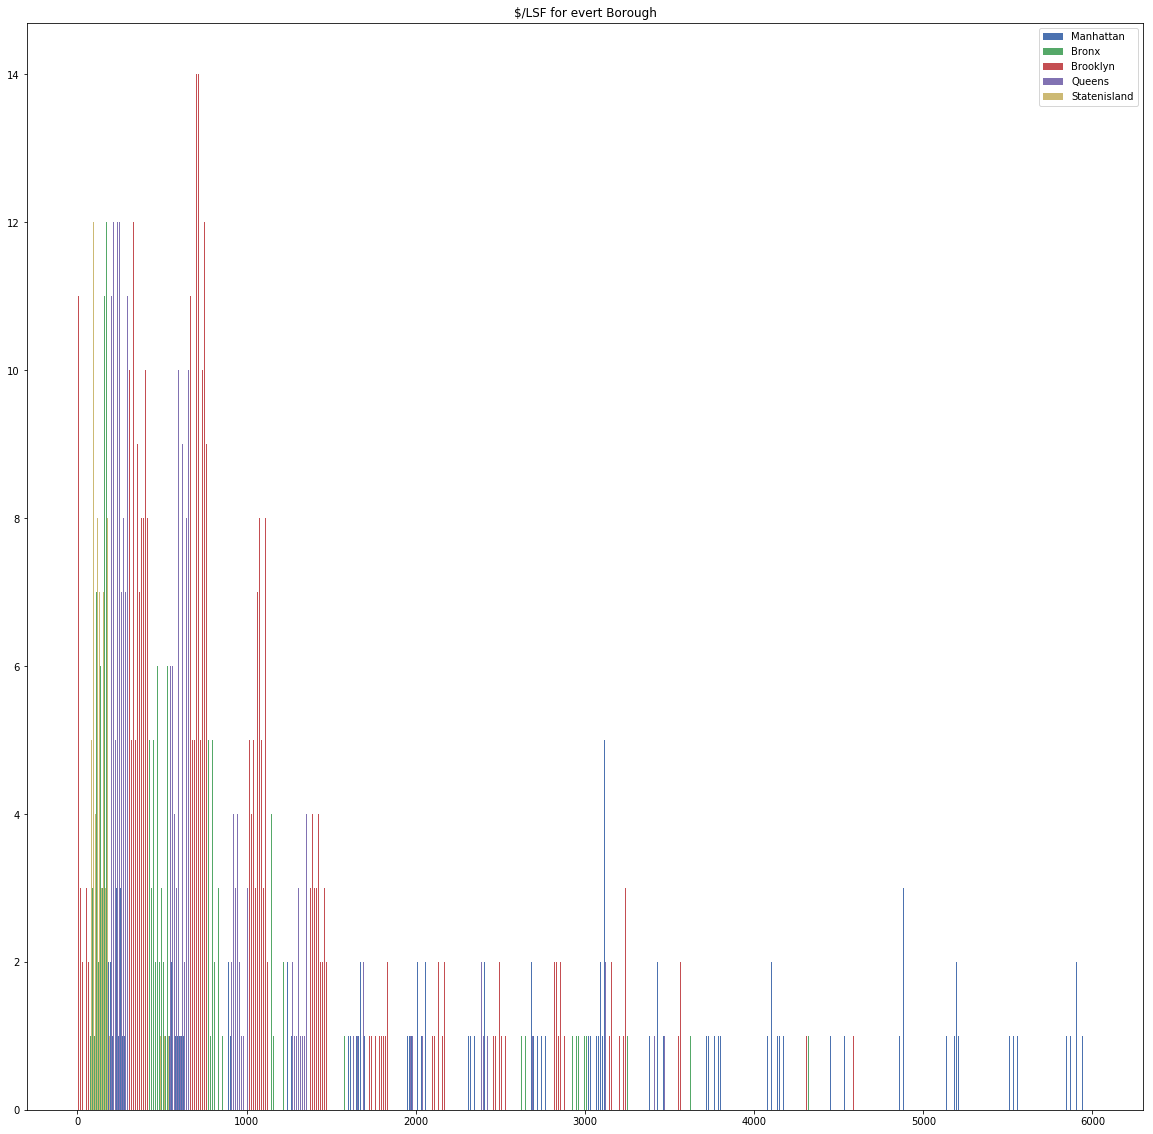

In [45]:
bins = np.linspace(0, 6000, 500)
plt.figure(figsize=(20, 20))
plt.style.use("seaborn-deep")
plt.hist([a1, b1, c1, d1, e1], bins, label = ["Manhattan", "Bronx", "Brooklyn", "Queens", "Statenisland"])
plt.legend(loc="upper right")
plt.title("$/LSF for evert Borough")
plt.show()

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


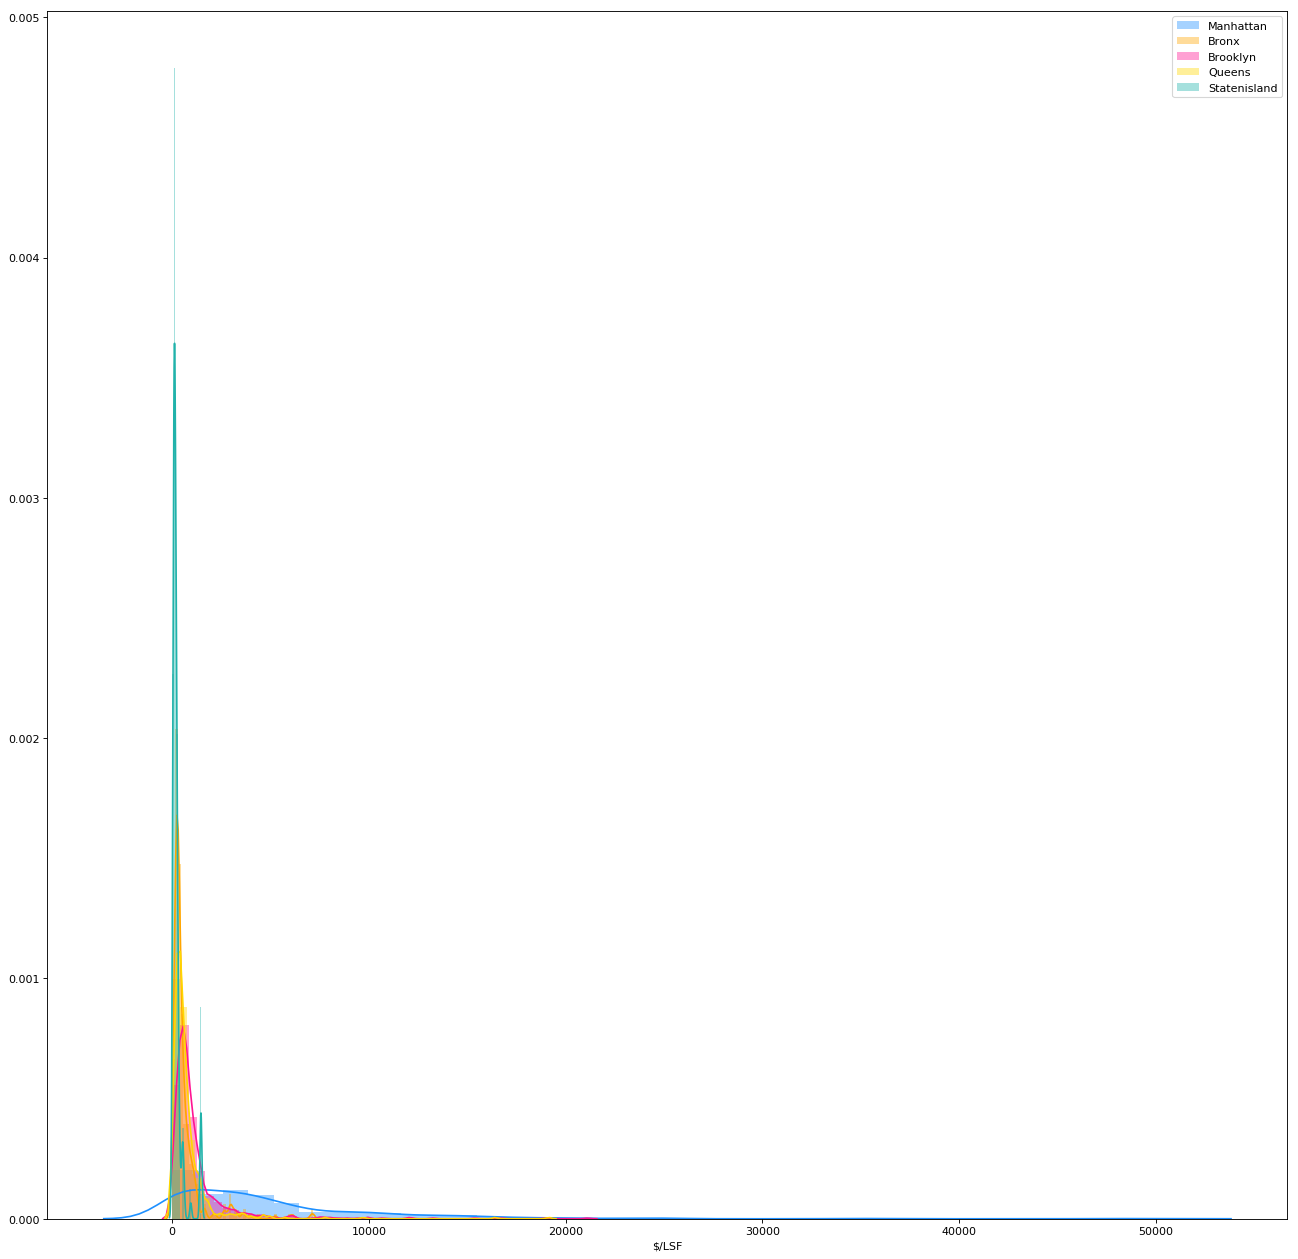

In [46]:
plt.figure(figsize=(20, 20), dpi= 80)
sns.distplot(a1, color="dodgerblue", label="Manhattan")
sns.distplot(b1, color="orange", label="Bronx")
sns.distplot(c1, color="deeppink", label="Brooklyn")
sns.distplot(d1, color="gold", label="Queens")
sns.distplot(e1, color="lightseagreen", label="Statenisland")
plt.legend()

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


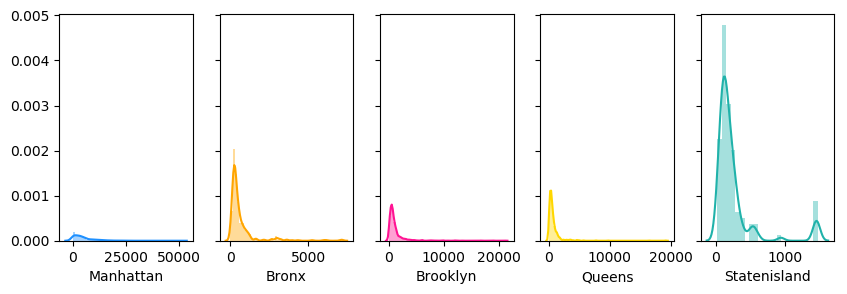

In [340]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True, dpi=100)

sns.distplot(a1, color="dodgerblue", ax=axes[0], axlabel="Manhattan")
sns.distplot(b1, color="orange", ax=axes[1], axlabel="Bronx")
sns.distplot(c1, color="deeppink", ax=axes[2], axlabel="Brooklyn")
sns.distplot(d1, color="gold", ax=axes[3], axlabel="Queens")
sns.distplot(e1, color="lightseagreen", ax=axes[4], axlabel="Statenisland")

*Plot for $/GSF*

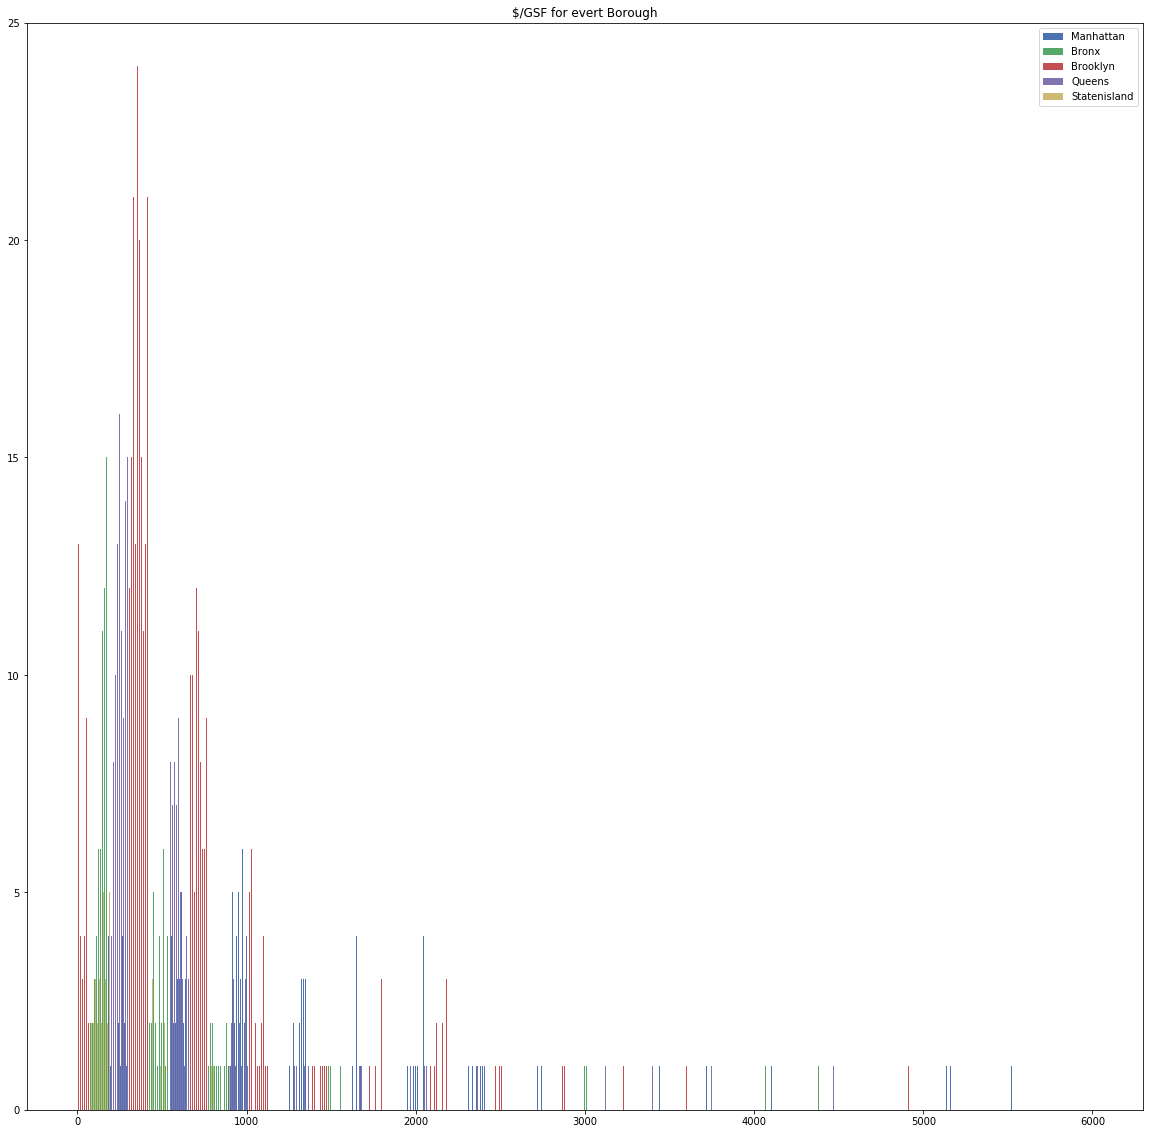

In [48]:
bins = np.linspace(0, 6000, 500)
plt.figure(figsize=(20, 20))
plt.style.use("seaborn-deep")
plt.hist([a2, b2, c2, d2, e2], bins, label = ["Manhattan", "Bronx", "Brooklyn", "Queens", "Statenisland"])
plt.legend(loc="upper right")
plt.title("$/GSF for evert Borough")
plt.ylim(0, 25)
plt.show()

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


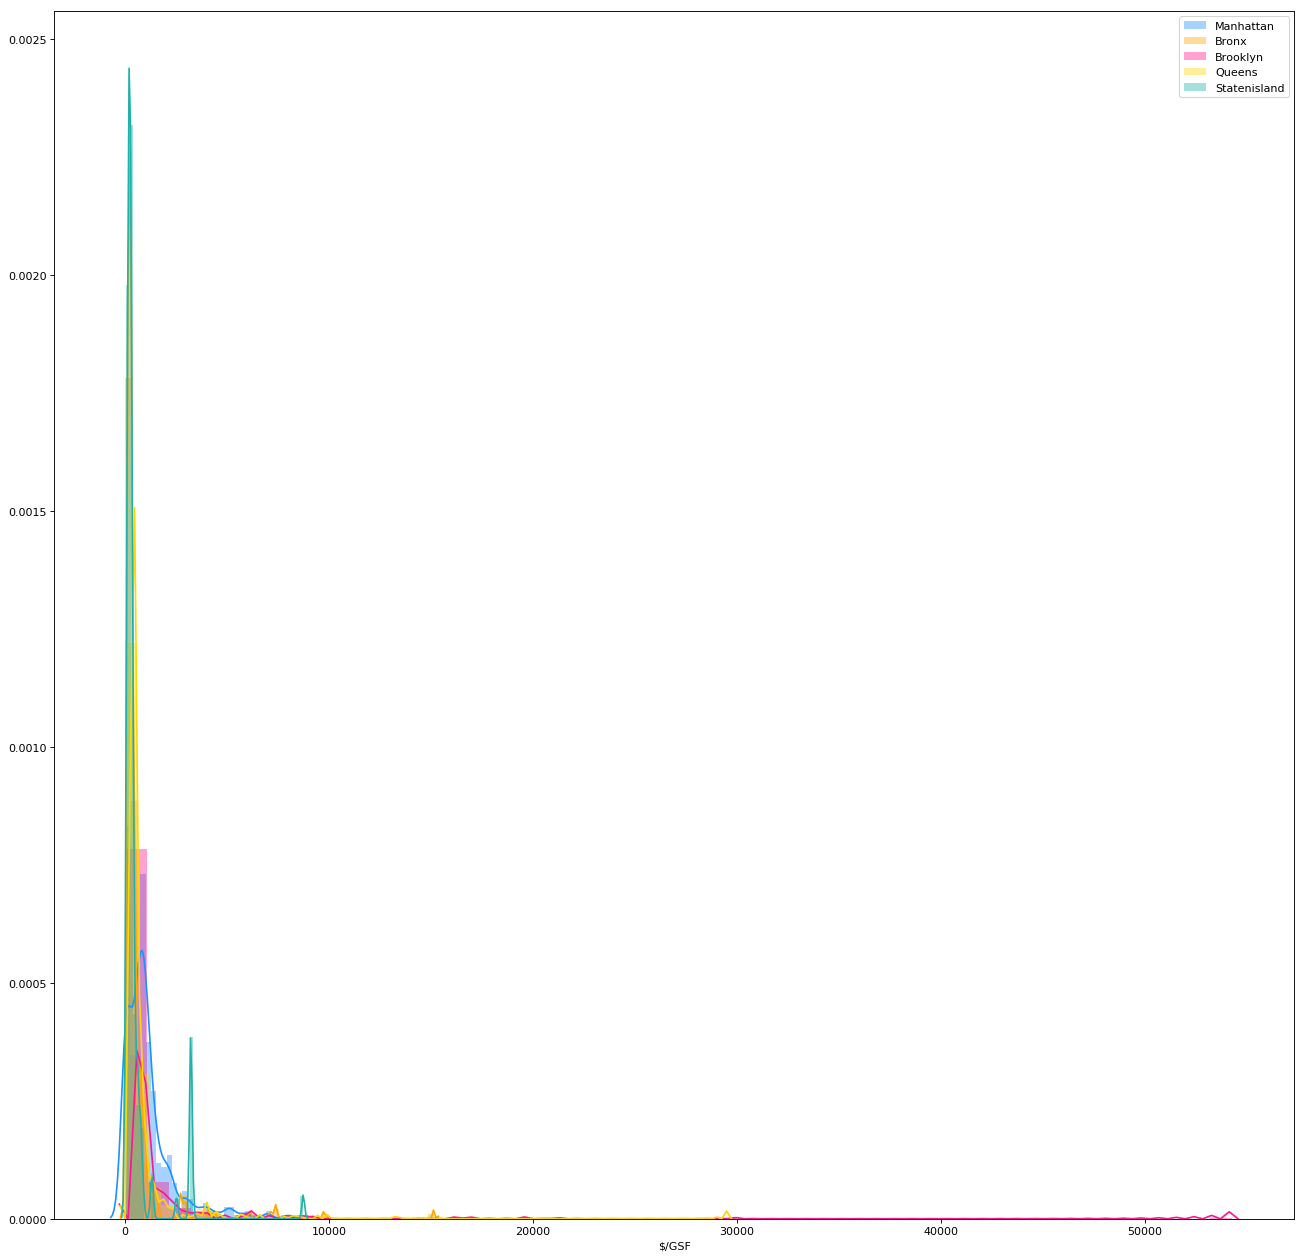

In [49]:
plt.figure(figsize=(20, 20), dpi= 80)
sns.distplot(a2, color="dodgerblue", label="Manhattan")
sns.distplot(b2, color="orange", label="Bronx")
sns.distplot(c2, color="deeppink", label="Brooklyn")
sns.distplot(d2, color="gold", label="Queens")
sns.distplot(e2, color="lightseagreen", label="Statenisland")
plt.legend()

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


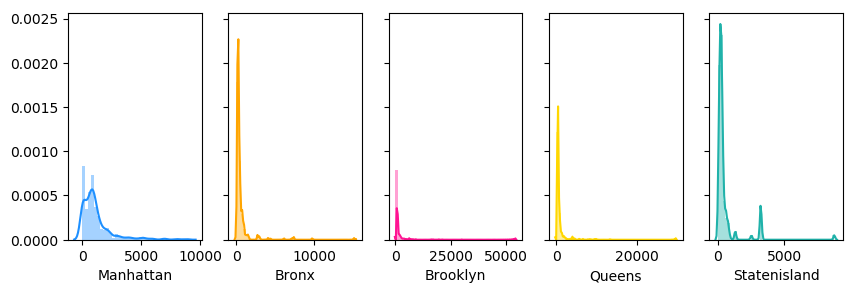

In [50]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True, dpi=100)

sns.distplot(a2, color="dodgerblue", ax=axes[0], axlabel="Manhattan")
sns.distplot(b2, color="orange", ax=axes[1], axlabel="Bronx")
sns.distplot(c2, color="deeppink", ax=axes[2], axlabel="Brooklyn")
sns.distplot(d2, color="gold", ax=axes[3], axlabel="Queens")
sns.distplot(e2, color="lightseagreen", ax=axes[4], axlabel="Statenisland")

*Since all these distributions are right skewed with different ranges, I hereby try to normalize all these distributions*

*Log method*

In [51]:
a1_log = np.log(a1)
b1_log = np.log(b1)
c1_log = np.log(c1)
d1_log = np.log(d1)
e1_log = np.log(e1)

a2_log = np.log(a2)
b2_log = np.log(b2)
c2_log = np.log(c2)
d2_log = np.log(d2)
e2_log = np.log(e2)

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


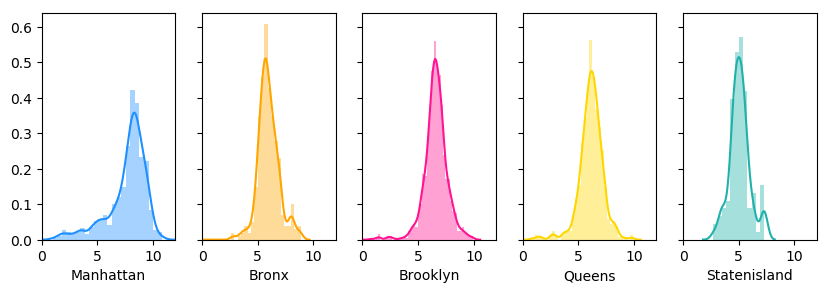

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True, dpi=100)

for i in range(0,5):
    axes[i].set_xlim(0, 12)
    i += 1

sns.distplot(a1_log, color="dodgerblue", ax=axes[0], axlabel="Manhattan")
sns.distplot(b1_log, color="orange", ax=axes[1], axlabel="Bronx")
sns.distplot(c1_log, color="deeppink", ax=axes[2], axlabel="Brooklyn")
sns.distplot(d1_log, color="gold", ax=axes[3], axlabel="Queens")
sns.distplot(e1_log, color="lightseagreen", ax=axes[4], axlabel="Statenisland")

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


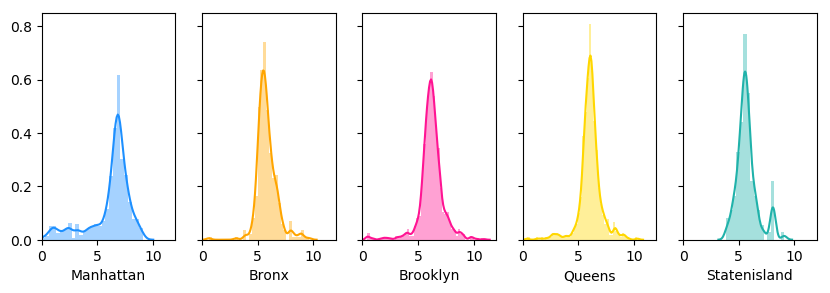

In [53]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True, dpi=100)

for i in range(0,5):
    axes[i].set_xlim(0, 12)
    i += 1

sns.distplot(a2_log, color="dodgerblue", ax=axes[0], axlabel="Manhattan")
sns.distplot(b2_log, color="orange", ax=axes[1], axlabel="Bronx")
sns.distplot(c2_log, color="deeppink", ax=axes[2], axlabel="Brooklyn")
sns.distplot(d2_log, color="gold", ax=axes[3], axlabel="Queens")
sns.distplot(e2_log, color="lightseagreen", ax=axes[4], axlabel="Statenisland")

*Results of square root method are still right skewed, so it is abandoned*

In [54]:
data_manhattan = pd.concat([a1_log, a2_log], axis = 1)
data_bronx = pd.concat([b1_log, b2_log], axis = 1)
data_brooklyn = pd.concat([c1_log, c2_log], axis = 1)
data_queens = pd.concat([d1_log, d2_log], axis = 1)
data_statenisland = pd.concat([e1_log, e2_log], axis = 1)

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


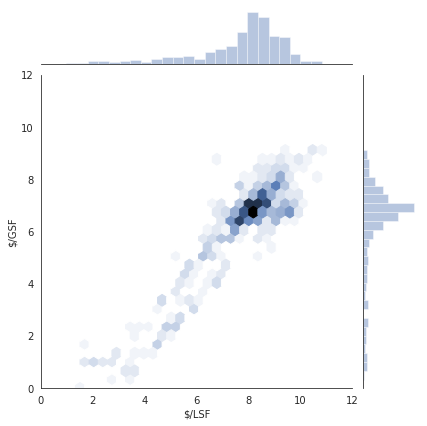

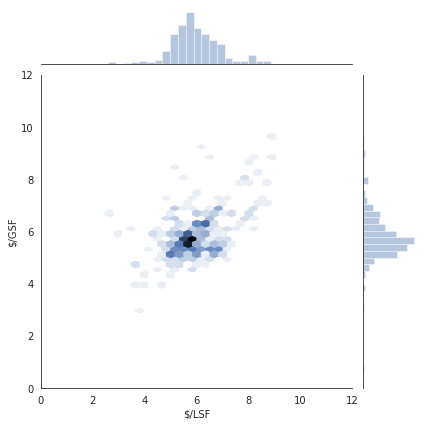

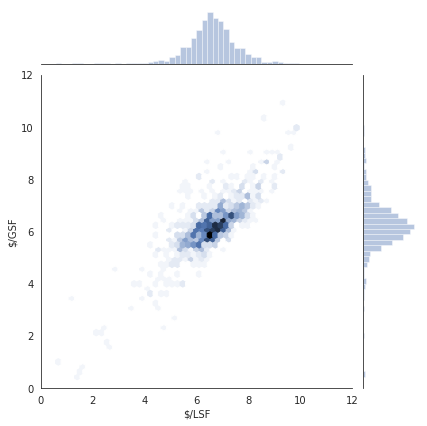

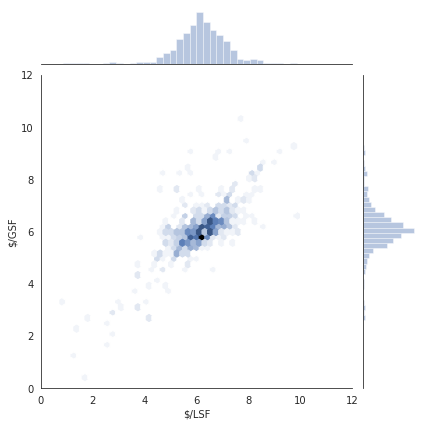

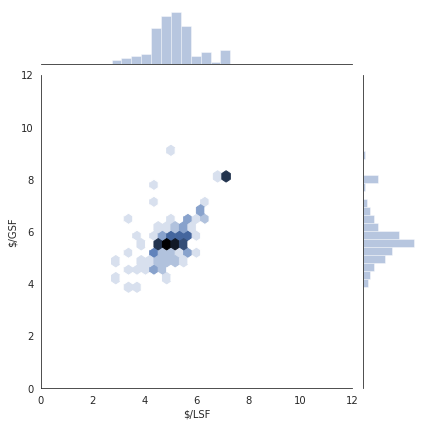

In [55]:
with sns.axes_style('white'):

    sns.jointplot("$/LSF", "$/GSF", data_manhattan, kind='hex', xlim=(0,12), ylim=(0,12))
    sns.jointplot("$/LSF", "$/GSF", data_bronx, kind='hex', xlim=(0,12), ylim=(0,12))
    sns.jointplot("$/LSF", "$/GSF", data_brooklyn, kind='hex', xlim=(0,12), ylim=(0,12))
    sns.jointplot("$/LSF", "$/GSF", data_queens, kind='hex', xlim=(0,12), ylim=(0,12))
    sns.jointplot("$/LSF", "$/GSF", data_statenisland, kind='hex', xlim=(0,12), ylim=(0,12))

### 6.2 Building Age

In [56]:
a3 = 2020 - ny_pricing[ny_pricing["BOROUGH"] == "Manhattan"]["YEAR BUILT"]
b3 = 2020 - ny_pricing[ny_pricing["BOROUGH"] == "Bronx"]["YEAR BUILT"]
c3 = 2020 - ny_pricing[ny_pricing["BOROUGH"] == "Brooklyn"]["YEAR BUILT"]
d3 = 2020 - ny_pricing[ny_pricing["BOROUGH"] == "Queens"]["YEAR BUILT"]
e3 = 2020 - ny_pricing[ny_pricing["BOROUGH"] == "Statenisland"]["YEAR BUILT"]

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


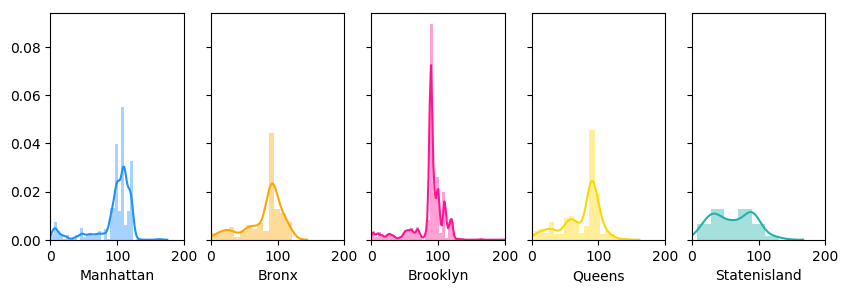

In [57]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True, dpi=100)

for i in range(0,5):
    axes[i].set_xlim(0, 200)
    i += 1

sns.distplot(a3, color="dodgerblue", ax=axes[0], axlabel="Manhattan")
sns.distplot(b3, color="orange", ax=axes[1], axlabel="Bronx")
sns.distplot(c3, color="deeppink", ax=axes[2], axlabel="Brooklyn")
sns.distplot(d3, color="gold", ax=axes[3], axlabel="Queens")
sns.distplot(e3, color="lightseagreen", ax=axes[4], axlabel="Statenisland")

In [58]:
a3_log = np.log(a3)
b3_log = np.log(b3)
c3_log = np.log(c3)
d3_log = np.log(d3)
e3_log = np.log(e3)

D:\Python\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


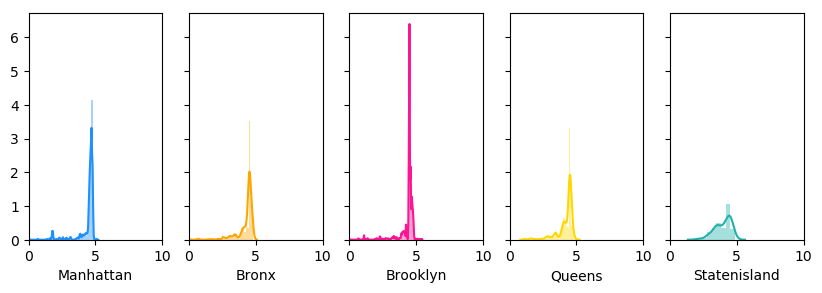

In [59]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3), sharey=True, dpi=100)

for i in range(0,5):
    axes[i].set_xlim(0, 10)
    i += 1

sns.distplot(a3_log, color="dodgerblue", ax=axes[0], axlabel="Manhattan")
sns.distplot(b3_log, color="orange", ax=axes[1], axlabel="Bronx")
sns.distplot(c3_log, color="deeppink", ax=axes[2], axlabel="Brooklyn")
sns.distplot(d3_log, color="gold", ax=axes[3], axlabel="Queens")
sns.distplot(e3_log, color="lightseagreen", ax=axes[4], axlabel="Statenisland")

### 6.3 Mapping

In [60]:
ny_lsf = a1_log.append(b1_log, ignore_index=True)
ny_lsf = ny_lsf.append(c1_log, ignore_index=True)
ny_lsf = ny_lsf.append(d1_log, ignore_index=True)
ny_lsf = ny_lsf.append(e1_log, ignore_index=True)

In [61]:
ny_gsf = a2_log.append(b2_log, ignore_index=True)
ny_gsf = ny_gsf.append(c2_log, ignore_index=True)
ny_gsf = ny_gsf.append(d2_log, ignore_index=True)
ny_gsf = ny_gsf.append(e2_log, ignore_index=True)

In [62]:
ny_age = a3.append(b3, ignore_index=True)
ny_age = ny_age.append(c3, ignore_index=True)
ny_age = ny_age.append(d3, ignore_index=True)
ny_age = ny_age.append(e3, ignore_index=True)

In [63]:
ny_tag = ny_pricing[["BOROUGH", "NEIGHBORHOOD"]]
ny_crp = pd.concat([ny_tag, ny_lsf, ny_gsf, ny_age], axis = 1)
ny_crp.head()

,BOROUGH,NEIGHBORHOOD,$/LSF,$/GSF,YEAR BUILT
0,Manhattan,ALPHABET CITY,7.333742,6.767999,80.0
1,Manhattan,ALPHABET CITY,8.009732,6.685873,100.0
2,Manhattan,ALPHABET CITY,5.878828,4.682502,100.0
3,Manhattan,ALPHABET CITY,4.725084,3.355851,100.0
4,Manhattan,ALPHABET CITY,3.789177,2.302585,120.0


In [64]:
ny_crp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474 entries, 0 to 2473
Data columns (total 5 columns):
BOROUGH         2474 non-null object
NEIGHBORHOOD    2474 non-null object
$/LSF           2474 non-null float64
$/GSF           2474 non-null float64
YEAR BUILT      2474 non-null float64
dtypes: float64(3), object(2)
memory usage: 96.8+ KB


In [65]:
ny_crp_clean = ny_crp.groupby(["BOROUGH", "NEIGHBORHOOD"]).mean().reset_index()
ny_crp_clean

,BOROUGH,NEIGHBORHOOD,$/LSF,$/GSF,YEAR BUILT
0,Bronx,BATHGATE,5.850688,5.655564,65.312500
1,Bronx,BAYCHESTER,5.206168,5.765126,70.533333
2,Bronx,BEDFORD PARK/NORWOOD,6.688893,6.102262,73.800000
3,Bronx,BELMONT,6.862201,5.814513,100.857143
4,Bronx,BRONX PARK,6.606393,5.488111,14.000000
...,...,...,...,...,...
213,Statenisland,TOTTENVILLE,4.108657,4.863794,80.333333
214,Statenisland,TRAVIS,5.482845,5.419871,9.000000
215,Statenisland,WEST NEW BRIGHTON,4.652403,5.337265,72.538462
216,Statenisland,WESTERLEIGH,5.721912,5.882795,29.000000


In [66]:
for i in range (0, 218):
    if ny_crp_clean["BOROUGH"][i] == "Statenisland":
        ny_crp_clean["BOROUGH"][i] = "Staten Island"
        i += 1
    else:
        i += 1
        
ny_crp_clean

D:\Python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,BOROUGH,NEIGHBORHOOD,$/LSF,$/GSF,YEAR BUILT
0,Bronx,BATHGATE,5.850688,5.655564,65.312500
1,Bronx,BAYCHESTER,5.206168,5.765126,70.533333
2,Bronx,BEDFORD PARK/NORWOOD,6.688893,6.102262,73.800000
3,Bronx,BELMONT,6.862201,5.814513,100.857143
4,Bronx,BRONX PARK,6.606393,5.488111,14.000000
...,...,...,...,...,...
213,Staten Island,TOTTENVILLE,4.108657,4.863794,80.333333
214,Staten Island,TRAVIS,5.482845,5.419871,9.000000
215,Staten Island,WEST NEW BRIGHTON,4.652403,5.337265,72.538462
216,Staten Island,WESTERLEIGH,5.721912,5.882795,29.000000


*In order to merge, we have to make some adjustments to our dataframes*

In [67]:
ny_crp_clean.rename(columns={"BOROUGH":"Borough", "NEIGHBORHOOD":"Neighborhood"}, inplace=True)
new_york_data["Neighborhood"] = new_york_data["Neighborhood"].str.upper()

In [68]:
new_york_data

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,WAKEFIELD,40.894705,-73.847201
1,Bronx,CO-OP CITY,40.874294,-73.829939
2,Bronx,EASTCHESTER,40.887556,-73.827806
3,Bronx,FIELDSTON,40.895437,-73.905643
4,Bronx,RIVERDALE,40.890834,-73.912585
...,...,...,...,...
301,Manhattan,HUDSON YARDS,40.756658,-74.000111
302,Queens,HAMMELS,40.587338,-73.805530
303,Queens,BAYSWATER,40.611322,-73.765968
304,Queens,QUEENSBRIDGE,40.756091,-73.945631


In [266]:
ny_crp_merge = pd.merge(ny_crp_clean, new_york_data, on='Neighborhood')
ny_crp_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 8 columns):
Borough_x       145 non-null object
Neighborhood    145 non-null object
$/LSF           145 non-null float64
$/GSF           145 non-null float64
YEAR BUILT      145 non-null float64
Borough_y       145 non-null object
Latitude        145 non-null float64
Longitude       145 non-null float64
dtypes: float64(5), object(3)
memory usage: 10.2+ KB


*Check if there is any record doesn't have lat & lon*

In [267]:
print(ny_crp_merge["Latitude"].isnull().sum())
print(ny_crp_merge["Longitude"].isnull().sum())

0
0


*Check if there is any same name in different Boroughs*

In [268]:
n = 0
for i in range (0,145):
    if ny_crp_merge["Borough_x"][i] != ny_crp_merge["Borough_y"][i]:
        n += 1
        i += 1
    else:
        i += 1
        
n

4

In [269]:
pd.set_option('display.max_rows', 150)
ny_crp_merge

,Borough_x,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Borough_y,Latitude,Longitude
0,Bronx,BAYCHESTER,5.206168,5.765126,70.533333,Bronx,40.866858,-73.835798
1,Bronx,BELMONT,6.862201,5.814513,100.857143,Bronx,40.857277,-73.888452
2,Bronx,BRONXDALE,5.675977,5.780660,64.777778,Bronx,40.852723,-73.861726
3,Bronx,CITY ISLAND,5.032875,6.195892,93.600000,Bronx,40.847247,-73.786488
4,Bronx,COUNTRY CLUB,4.140857,5.839743,59.500000,Bronx,40.844246,-73.824099
5,Bronx,EAST TREMONT,5.876357,5.676568,94.888889,Bronx,40.842696,-73.887356
6,Bronx,FIELDSTON,5.901212,6.324950,100.000000,Bronx,40.895437,-73.905643
7,Bronx,FORDHAM,6.541999,5.611636,96.750000,Bronx,40.860997,-73.896427
8,Bronx,HUNTS POINT,5.755462,6.016204,64.476190,Bronx,40.809730,-73.883315
9,Bronx,PARKCHESTER,5.724147,5.628195,89.600000,Bronx,40.837938,-73.856003


*Delete these duplicates*

In [270]:
ny_crp_merge = ny_crp_merge[ny_crp_merge["Borough_x"] == ny_crp_merge["Borough_y"]]
ny_crp_merge.head()

,Borough_x,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Borough_y,Latitude,Longitude
0,Bronx,BAYCHESTER,5.206168,5.765126,70.533333,Bronx,40.866858,-73.835798
1,Bronx,BELMONT,6.862201,5.814513,100.857143,Bronx,40.857277,-73.888452
2,Bronx,BRONXDALE,5.675977,5.780660,64.777778,Bronx,40.852723,-73.861726
3,Bronx,CITY ISLAND,5.032875,6.195892,93.600000,Bronx,40.847247,-73.786488
4,Bronx,COUNTRY CLUB,4.140857,5.839743,59.500000,Bronx,40.844246,-73.824099


In [271]:
ny_crp_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141 entries, 0 to 144
Data columns (total 8 columns):
Borough_x       141 non-null object
Neighborhood    141 non-null object
$/LSF           141 non-null float64
$/GSF           141 non-null float64
YEAR BUILT      141 non-null float64
Borough_y       141 non-null object
Latitude        141 non-null float64
Longitude       141 non-null float64
dtypes: float64(5), object(3)
memory usage: 9.9+ KB


*Cleaning dataframe*

In [272]:
ny_crp_merge.drop(["Borough_y"], axis = 1, inplace=True)
ny_crp_merge.rename(columns={"Borough_x":"Borough"}, inplace=True)

D:\Python\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
D:\Python\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [273]:
ny_crp_merge.reset_index(drop=True)

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,BAYCHESTER,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,BELMONT,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,BRONXDALE,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,CITY ISLAND,5.032875,6.195892,93.600000,40.847247,-73.786488
4,Bronx,COUNTRY CLUB,4.140857,5.839743,59.500000,40.844246,-73.824099
5,Bronx,EAST TREMONT,5.876357,5.676568,94.888889,40.842696,-73.887356
6,Bronx,FIELDSTON,5.901212,6.324950,100.000000,40.895437,-73.905643
7,Bronx,FORDHAM,6.541999,5.611636,96.750000,40.860997,-73.896427
8,Bronx,HUNTS POINT,5.755462,6.016204,64.476190,40.809730,-73.883315
9,Bronx,PARKCHESTER,5.724147,5.628195,89.600000,40.837938,-73.856003


In [274]:
ny_crp_merge["Neighborhood"] = ny_crp_merge["Neighborhood"].str.title()
ny_crp_merge

D:\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,City Island,5.032875,6.195892,93.600000,40.847247,-73.786488
4,Bronx,Country Club,4.140857,5.839743,59.500000,40.844246,-73.824099
5,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
6,Bronx,Fieldston,5.901212,6.324950,100.000000,40.895437,-73.905643
7,Bronx,Fordham,6.541999,5.611636,96.750000,40.860997,-73.896427
8,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
9,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003


=== Massive Cleaning Process ===

*Since the geojson has some neighborhoods merged together , we have to manually check & merge (some information lose here due to inadequate data)*

In [275]:
ny_crp_merge["Neighborhood"][0] = "Eastchester-Edenwald-Baychester"

D:\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Python\lib\site-packages\IPython\core\interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [276]:
ny_crp_merge

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,City Island,5.032875,6.195892,93.600000,40.847247,-73.786488
4,Bronx,Country Club,4.140857,5.839743,59.500000,40.844246,-73.824099
5,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
6,Bronx,Fieldston,5.901212,6.324950,100.000000,40.895437,-73.905643
7,Bronx,Fordham,6.541999,5.611636,96.750000,40.860997,-73.896427
8,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
9,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003


In [277]:
ny_crp_merge_2 = ny_crp_merge

In [278]:
ny_crp_merge_2.loc[3, "Neighborhood"] = "Pelham Bay-Country Club-City Island"
ny_crp_merge_2.loc[3, "$/LSF"] = (ny_crp_merge_2.loc[3, "$/LSF"] + ny_crp_merge_2.loc[4, "$/LSF"])/2
ny_crp_merge_2.loc[3, "$/GSF"] = (ny_crp_merge_2.loc[3, "$/GSF"] + ny_crp_merge_2.loc[4, "$/GSF"])/2
ny_crp_merge_2.loc[3, "YEAR BUILT"] = (ny_crp_merge_2.loc[3, "YEAR BUILT"] + ny_crp_merge_2.loc[4, "YEAR BUILT"])/2
ny_crp_merge_2.loc[3, "Latitude"] = (ny_crp_merge_2.loc[3, "Latitude"] + ny_crp_merge_2.loc[4, "Latitude"])/2
ny_crp_merge_2.loc[3, "Longitude"] = (ny_crp_merge_2.loc[3, "Longitude"] + ny_crp_merge_2.loc[4, "Longitude"])/2
ny_crp_merge_2

D:\Python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,Country Club,4.140857,5.839743,59.500000,40.844246,-73.824099
5,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
6,Bronx,Fieldston,5.901212,6.324950,100.000000,40.895437,-73.905643
7,Bronx,Fordham,6.541999,5.611636,96.750000,40.860997,-73.896427
8,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
9,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003


In [279]:
ny_crp_merge_2.drop([4],inplace=True)
ny_crp_merge_2

D:\Python\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
5,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
6,Bronx,Fieldston,5.901212,6.324950,100.000000,40.895437,-73.905643
7,Bronx,Fordham,6.541999,5.611636,96.750000,40.860997,-73.896427
8,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
9,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
10,Bronx,Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [280]:
ny_crp_merge_2.loc[6, "Neighborhood"] = "North Riverdale-Fieldston-Riverdale"
ny_crp_merge_2.loc[6, "$/LSF"] = (ny_crp_merge_2.loc[6, "$/LSF"] + ny_crp_merge_2.loc[11, "$/LSF"])/2
ny_crp_merge_2.loc[6, "$/GSF"] = (ny_crp_merge_2.loc[6, "$/GSF"] + ny_crp_merge_2.loc[11, "$/GSF"])/2
ny_crp_merge_2.loc[6, "YEAR BUILT"] = (ny_crp_merge_2.loc[6, "YEAR BUILT"] + ny_crp_merge_2.loc[11, "YEAR BUILT"])/2
ny_crp_merge_2.loc[6, "Latitude"] = (ny_crp_merge_2.loc[6, "Latitude"] + ny_crp_merge_2.loc[11, "Latitude"])/2
ny_crp_merge_2.loc[6, "Longitude"] = (ny_crp_merge_2.loc[6, "Longitude"] + ny_crp_merge_2.loc[11, "Longitude"])/2
ny_crp_merge_2.drop([11],inplace=True)

D:\Python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Python\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [281]:
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
5,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
6,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
7,Bronx,Fordham,6.541999,5.611636,96.750000,40.860997,-73.896427
8,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
9,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
10,Bronx,Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [282]:
ny_crp_merge_2.loc[7, "Neighborhood"] = "Fordham South"
ny_crp_merge_2.loc[10, "Neighborhood"] = "Allerton-Pelham Gardens"
ny_crp_merge_2.loc[12, "Neighborhood"] = "Soundview-Bruckner"
ny_crp_merge_2.loc[13, "Neighborhood"] = "Schuylerville-Throgs Neck-Edgewater Park"

D:\Python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [283]:
ny_crp_merge_2.loc[14, "Neighborhood"] = "Woodlawn-Wakefield"
ny_crp_merge_2.loc[14, "$/LSF"] = (ny_crp_merge_2.loc[14, "$/LSF"] + ny_crp_merge_2.loc[16, "$/LSF"])/2
ny_crp_merge_2.loc[14, "$/GSF"] = (ny_crp_merge_2.loc[14, "$/GSF"] + ny_crp_merge_2.loc[16, "$/GSF"])/2
ny_crp_merge_2.loc[14, "YEAR BUILT"] = (ny_crp_merge_2.loc[14, "YEAR BUILT"] + ny_crp_merge_2.loc[16, "YEAR BUILT"])/2
ny_crp_merge_2.loc[14, "Latitude"] = (ny_crp_merge_2.loc[14, "Latitude"] + ny_crp_merge_2.loc[16, "Latitude"])/2
ny_crp_merge_2.loc[14, "Longitude"] = (ny_crp_merge_2.loc[14, "Longitude"] + ny_crp_merge_2.loc[16, "Longitude"])/2
ny_crp_merge_2.drop([16],inplace=True)

D:\Python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\Python\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [284]:
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
5,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
6,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
7,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
8,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
9,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
10,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [285]:
ny_crp_merge_2.loc[15, "Neighborhood"] = "Williamsbridge-Olinville"
ny_crp_merge_2.loc[19, "Neighborhood"] = "Bedford"

D:\Python\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [286]:
ny_crp_merge_2 = ny_crp_merge_2.append(ny_crp_merge_2.loc[19], ignore_index=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [287]:
ny_crp_merge_2.loc[138, "Neighborhood"] = "Stuyvesant Heights"
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [288]:
ny_crp_merge_2 = ny_crp_merge_2.append(ny_crp_merge_2.loc[17],ignore_index=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [289]:
ny_crp_merge_2.loc[17, "Neighborhood"] = "Bensonhurst East"
ny_crp_merge_2.loc[139, "Neighborhood"] = "Bensonhurst West"

In [290]:
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [291]:
ny_crp_merge_2.loc[18, "Neighborhood"] = "Georgetown-Marine Park-Bergen Beach-Mill Basin"
ny_crp_merge_2.loc[18, "$/LSF"] = (ny_crp_merge_2.loc[18, "$/LSF"] + ny_crp_merge_2.loc[43, "$/LSF"] + ny_crp_merge_2.loc[45, "$/LSF"])/3
ny_crp_merge_2.loc[18, "$/GSF"] = (ny_crp_merge_2.loc[18, "$/GSF"] + ny_crp_merge_2.loc[43, "$/GSF"] + ny_crp_merge_2.loc[45, "$/GSF"])/3
ny_crp_merge_2.loc[18, "YEAR BUILT"] = (ny_crp_merge_2.loc[18, "YEAR BUILT"] + ny_crp_merge_2.loc[43, "YEAR BUILT"] + ny_crp_merge_2.loc[45, "YEAR BUILT"])/3
ny_crp_merge_2.loc[18, "Latitude"] = (ny_crp_merge_2.loc[18, "Latitude"] + ny_crp_merge_2.loc[43, "Latitude"] + ny_crp_merge_2.loc[45, "Latitude"])/3
ny_crp_merge_2.loc[18, "Longitude"] = (ny_crp_merge_2.loc[18, "Longitude"] + ny_crp_merge_2.loc[43, "Longitude"] + ny_crp_merge_2.loc[45, "Longitude"])/3
ny_crp_merge_2.drop([43, 45],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [292]:
ny_crp_merge_2.loc[22, "Neighborhood"] = "Brooklyn Heights-Cobble Hill"
ny_crp_merge_2.loc[22, "$/LSF"] = (ny_crp_merge_2.loc[22, "$/LSF"] + ny_crp_merge_2.loc[28, "$/LSF"])/2
ny_crp_merge_2.loc[22, "$/GSF"] = (ny_crp_merge_2.loc[22, "$/GSF"] + ny_crp_merge_2.loc[28, "$/GSF"])/2
ny_crp_merge_2.loc[22, "YEAR BUILT"] = (ny_crp_merge_2.loc[22, "YEAR BUILT"] + ny_crp_merge_2.loc[28, "YEAR BUILT"])/2
ny_crp_merge_2.loc[22, "Latitude"] = (ny_crp_merge_2.loc[22, "Latitude"] + ny_crp_merge_2.loc[28, "Latitude"])/2
ny_crp_merge_2.loc[22, "Longitude"] = (ny_crp_merge_2.loc[22, "Longitude"] + ny_crp_merge_2.loc[28, "Longitude"])/2
ny_crp_merge_2.drop([28],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [293]:
ny_crp_merge_2 = ny_crp_merge_2.append(ny_crp_merge_2.loc[24], ignore_index=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [294]:
ny_crp_merge_2.loc[24, "Neighborhood"] = "Bushwick South"
ny_crp_merge_2.loc[137, "Neighborhood"] = "Bushwick North"

In [295]:
ny_crp_merge_2.loc[26, "Neighborhood"] = "Carroll Gardens-Columbia Street-Red Hook"
ny_crp_merge_2.loc[26, "$/LSF"] = (ny_crp_merge_2.loc[26, "$/LSF"] + ny_crp_merge_2.loc[46, "$/LSF"])/2
ny_crp_merge_2.loc[26, "$/GSF"] = (ny_crp_merge_2.loc[26, "$/GSF"] + ny_crp_merge_2.loc[46, "$/GSF"])/2
ny_crp_merge_2.loc[26, "YEAR BUILT"] = (ny_crp_merge_2.loc[26, "YEAR BUILT"] + ny_crp_merge_2.loc[46, "YEAR BUILT"])/2
ny_crp_merge_2.loc[26, "Latitude"] = (ny_crp_merge_2.loc[26, "Latitude"] + ny_crp_merge_2.loc[46, "Latitude"])/2
ny_crp_merge_2.loc[26, "Longitude"] = (ny_crp_merge_2.loc[26, "Longitude"] + ny_crp_merge_2.loc[46, "Longitude"])/2
ny_crp_merge_2.drop([46],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [296]:
ny_crp_merge_2.loc[28, "Neighborhood"] = "Seagate-Coney Island"

In [297]:
ny_crp_merge_2.loc[29, "Neighborhood"] = "Crown Heights North"

In [298]:
ny_crp_merge_2.loc[30, "Neighborhood"] = "Cypress Hills-City Line"

In [299]:
ny_crp_merge_2.loc[32, "Neighborhood"] = "East New York (Pennsylvania Ave)"

In [300]:
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [301]:
ny_crp_merge_2.loc[35, "Neighborhood"] = "Sheepshead Bay-Gerritsen Beach-Manhattan Beach"
ny_crp_merge_2.loc[35, "$/LSF"] = (ny_crp_merge_2.loc[35, "$/LSF"] + ny_crp_merge_2.loc[41, "$/LSF"] + ny_crp_merge_2.loc[47, "$/LSF"])/3
ny_crp_merge_2.loc[35, "$/GSF"] = (ny_crp_merge_2.loc[35, "$/GSF"] + ny_crp_merge_2.loc[41, "$/GSF"] + ny_crp_merge_2.loc[47, "$/GSF"])/3
ny_crp_merge_2.loc[35, "YEAR BUILT"] = (ny_crp_merge_2.loc[35, "YEAR BUILT"] + ny_crp_merge_2.loc[41, "YEAR BUILT"] + ny_crp_merge_2.loc[47, "YEAR BUILT"])/3
ny_crp_merge_2.loc[35, "Latitude"] = (ny_crp_merge_2.loc[35, "Latitude"] + ny_crp_merge_2.loc[41, "Latitude"] + ny_crp_merge_2.loc[47, "Latitude"])/3
ny_crp_merge_2.loc[35, "Longitude"] = (ny_crp_merge_2.loc[35, "Longitude"] + ny_crp_merge_2.loc[41, "Longitude"] + ny_crp_merge_2.loc[47, "Longitude"])/3
ny_crp_merge_2.drop([41, 47],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [302]:
ny_crp_merge_2.loc[36, "Neighborhood"] = "Park Slope-Gowanus"
ny_crp_merge_2.loc[36, "$/LSF"] = (ny_crp_merge_2.loc[36, "$/LSF"] + ny_crp_merge_2.loc[44, "$/LSF"])/2
ny_crp_merge_2.loc[36, "$/GSF"] = (ny_crp_merge_2.loc[36, "$/GSF"] + ny_crp_merge_2.loc[44, "$/GSF"])/2
ny_crp_merge_2.loc[36, "YEAR BUILT"] = (ny_crp_merge_2.loc[36, "YEAR BUILT"] + ny_crp_merge_2.loc[44, "YEAR BUILT"])/2
ny_crp_merge_2.loc[36, "Latitude"] = (ny_crp_merge_2.loc[36, "Latitude"] + ny_crp_merge_2.loc[44, "Latitude"])/2
ny_crp_merge_2.loc[36, "Longitude"] = (ny_crp_merge_2.loc[36, "Longitude"] + ny_crp_merge_2.loc[44, "Longitude"])/2
ny_crp_merge_2.drop([44],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [303]:
ny_crp_merge_2.loc[39, "Neighborhood"] = "Kensington-Ocean Parkway"

In [304]:
ny_crp_merge_2 = ny_crp_merge_2.append(ny_crp_merge_2.loc[48], ignore_index=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [305]:
ny_crp_merge_2.loc[44, "Neighborhood"] = "Sunset Park East"
ny_crp_merge_2.loc[134, "Neighborhood"] = "Sunset Park West"

In [306]:
ny_crp_merge_2.loc[46, "Neighborhood"] = "Hudson Yards-Chelsea-Flatiron-Union Square"
ny_crp_merge_2.loc[46, "$/LSF"] = (ny_crp_merge_2.loc[46, "$/LSF"] + ny_crp_merge_2.loc[51, "$/LSF"])/2
ny_crp_merge_2.loc[46, "$/GSF"] = (ny_crp_merge_2.loc[46, "$/GSF"] + ny_crp_merge_2.loc[51, "$/GSF"])/2
ny_crp_merge_2.loc[46, "YEAR BUILT"] = (ny_crp_merge_2.loc[46, "YEAR BUILT"] + ny_crp_merge_2.loc[51, "YEAR BUILT"])/2
ny_crp_merge_2.loc[46, "Latitude"] = (ny_crp_merge_2.loc[46, "Latitude"] + ny_crp_merge_2.loc[51, "Latitude"])/2
ny_crp_merge_2.loc[46, "Longitude"] = (ny_crp_merge_2.loc[46, "Longitude"] + ny_crp_merge_2.loc[51, "Longitude"])/2
ny_crp_merge_2.drop([51],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [307]:
ny_crp_merge_2.loc[48, "Neighborhood"] = "SoHo-TriBeCa-Civic Center-Little Italy"
ny_crp_merge_2.loc[48, "$/LSF"] = (ny_crp_merge_2.loc[48, "$/LSF"] + ny_crp_merge_2.loc[54, "$/LSF"] + ny_crp_merge_2.loc[58, "$/LSF"] + ny_crp_merge_2.loc[59, "$/LSF"])/4
ny_crp_merge_2.loc[48, "$/GSF"] = (ny_crp_merge_2.loc[48, "$/GSF"] + ny_crp_merge_2.loc[54, "$/GSF"] + ny_crp_merge_2.loc[58, "$/GSF"] + ny_crp_merge_2.loc[59, "$/GSF"])/4
ny_crp_merge_2.loc[48, "YEAR BUILT"] = (ny_crp_merge_2.loc[48, "YEAR BUILT"] + ny_crp_merge_2.loc[54, "YEAR BUILT"] + ny_crp_merge_2.loc[58, "YEAR BUILT"] + ny_crp_merge_2.loc[59, "YEAR BUILT"])/4
ny_crp_merge_2.loc[48, "Latitude"] = (ny_crp_merge_2.loc[48, "Latitude"] + ny_crp_merge_2.loc[54, "Latitude"] + ny_crp_merge_2.loc[58, "Latitude"] + ny_crp_merge_2.loc[59, "Latitude"])/4
ny_crp_merge_2.loc[48, "Longitude"] = (ny_crp_merge_2.loc[48, "Longitude"] + ny_crp_merge_2.loc[54, "Longitude"] + ny_crp_merge_2.loc[58, "Longitude"] + ny_crp_merge_2.loc[59, "Longitude"])/4
ny_crp_merge_2.drop([54, 58, 59],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [308]:
ny_crp_merge_2.loc[53, "Neighborhood"] = "Marble Hill-Inwood"

In [309]:
ny_crp_merge_2.loc[57, "Neighborhood"] = "Murray Hill-Kips Bay"

In [310]:
ny_crp_merge_2.loc[60, "Neighborhood"] = "Hammels-Arverne-Edgemere"
ny_crp_merge_2.loc[60, "$/LSF"] = (ny_crp_merge_2.loc[60, "$/LSF"] + ny_crp_merge_2.loc[77, "$/LSF"])/2
ny_crp_merge_2.loc[60, "$/GSF"] = (ny_crp_merge_2.loc[60, "$/GSF"] + ny_crp_merge_2.loc[77, "$/GSF"])/2
ny_crp_merge_2.loc[60, "YEAR BUILT"] = (ny_crp_merge_2.loc[60, "YEAR BUILT"] + ny_crp_merge_2.loc[77, "YEAR BUILT"])/2
ny_crp_merge_2.loc[60, "Latitude"] = (ny_crp_merge_2.loc[60, "Latitude"] + ny_crp_merge_2.loc[77, "Latitude"])/2
ny_crp_merge_2.loc[60, "Longitude"] = (ny_crp_merge_2.loc[60, "Longitude"] + ny_crp_merge_2.loc[77, "Longitude"])/2
ny_crp_merge_2.drop([77],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [311]:
ny_crp_merge_2.loc[62, "Neighborhood"] = "Bayside-Bayside Hills"

In [312]:
ny_crp_merge_2.loc[63, "Neighborhood"] = "Breezy Point-Belle Harbor-Rockaway Park-Broad Channel"
ny_crp_merge_2.loc[63, "$/LSF"] = (ny_crp_merge_2.loc[63, "$/LSF"] + ny_crp_merge_2.loc[95, "$/LSF"])/2
ny_crp_merge_2.loc[63, "$/GSF"] = (ny_crp_merge_2.loc[63, "$/GSF"] + ny_crp_merge_2.loc[95, "$/GSF"])/2
ny_crp_merge_2.loc[63, "YEAR BUILT"] = (ny_crp_merge_2.loc[63, "YEAR BUILT"] + ny_crp_merge_2.loc[95, "YEAR BUILT"])/2
ny_crp_merge_2.loc[63, "Latitude"] = (ny_crp_merge_2.loc[63, "Latitude"] + ny_crp_merge_2.loc[95, "Latitude"])/2
ny_crp_merge_2.loc[63, "Longitude"] = (ny_crp_merge_2.loc[63, "Longitude"] + ny_crp_merge_2.loc[95, "Longitude"])/2
ny_crp_merge_2.drop([95],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [313]:
ny_crp_merge_2.loc[65, "Neighborhood"] = "Briarwood-Jamaica Hills"
ny_crp_merge_2.loc[65, "$/LSF"] = (ny_crp_merge_2.loc[65, "$/LSF"] + ny_crp_merge_2.loc[82, "$/LSF"])/2
ny_crp_merge_2.loc[65, "$/GSF"] = (ny_crp_merge_2.loc[65, "$/GSF"] + ny_crp_merge_2.loc[82, "$/GSF"])/2
ny_crp_merge_2.loc[65, "YEAR BUILT"] = (ny_crp_merge_2.loc[65, "YEAR BUILT"] + ny_crp_merge_2.loc[82, "YEAR BUILT"])/2
ny_crp_merge_2.loc[65, "Latitude"] = (ny_crp_merge_2.loc[65, "Latitude"] + ny_crp_merge_2.loc[82, "Latitude"])/2
ny_crp_merge_2.loc[65, "Longitude"] = (ny_crp_merge_2.loc[65, "Longitude"] + ny_crp_merge_2.loc[82, "Longitude"])/2
ny_crp_merge_2.drop([82],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [314]:
ny_crp_merge_2.loc[69, "Neighborhood"] = "Douglas Manor-Douglaston-Little Neck"
ny_crp_merge_2.loc[69, "$/LSF"] = (ny_crp_merge_2.loc[69, "$/LSF"] + ny_crp_merge_2.loc[85, "$/LSF"])/2
ny_crp_merge_2.loc[69, "$/GSF"] = (ny_crp_merge_2.loc[69, "$/GSF"] + ny_crp_merge_2.loc[85, "$/GSF"])/2
ny_crp_merge_2.loc[69, "YEAR BUILT"] = (ny_crp_merge_2.loc[69, "YEAR BUILT"] + ny_crp_merge_2.loc[85, "YEAR BUILT"])/2
ny_crp_merge_2.loc[69, "Latitude"] = (ny_crp_merge_2.loc[69, "Latitude"] + ny_crp_merge_2.loc[85, "Latitude"])/2
ny_crp_merge_2.loc[69, "Longitude"] = (ny_crp_merge_2.loc[69, "Longitude"] + ny_crp_merge_2.loc[85, "Longitude"])/2
ny_crp_merge_2.drop([85],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [315]:
ny_crp_merge_2.loc[72, "Neighborhood"] = "Far Rockaway-Bayswater"

In [316]:
ny_crp_merge_2.loc[73, "Neighborhood"] = "Glen Oaks-Floral Park-New Hyde Park"
ny_crp_merge_2.loc[73, "$/LSF"] = (ny_crp_merge_2.loc[73, "$/LSF"] + ny_crp_merge_2.loc[75, "$/LSF"])/2
ny_crp_merge_2.loc[73, "$/GSF"] = (ny_crp_merge_2.loc[73, "$/GSF"] + ny_crp_merge_2.loc[75, "$/GSF"])/2
ny_crp_merge_2.loc[73, "YEAR BUILT"] = (ny_crp_merge_2.loc[73, "YEAR BUILT"] + ny_crp_merge_2.loc[75, "YEAR BUILT"])/2
ny_crp_merge_2.loc[73, "Latitude"] = (ny_crp_merge_2.loc[73, "Latitude"] + ny_crp_merge_2.loc[75, "Latitude"])/2
ny_crp_merge_2.loc[73, "Longitude"] = (ny_crp_merge_2.loc[73, "Longitude"] + ny_crp_merge_2.loc[75, "Longitude"])/2
ny_crp_merge_2.drop([75],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [317]:
ny_crp_merge_2.loc[79, "Neighborhood"] = "Jamaica Estates-Holliswood"

In [318]:
ny_crp_merge_2.loc[80, "Neighborhood"] = "Lindenwood-Howard Beach"

In [319]:
ny_crp_merge_2.loc[86, "Neighborhood"] = "Queensbridge-Ravenswood-Long Island City"

In [320]:
ny_crp_merge_2.loc[99, "Neighborhood"] = "Springfield Gardens North"

In [321]:
ny_crp_merge_2.loc[101, "Neighborhood"] = "Hunters Point-Sunnyside-West Maspeth"

*I once delete an area cannot be found, but recognize this is not necessary*

In [ ]:
ny_crp_merge_2.drop([102],inplace=True)

In [323]:
ny_crp_merge_2.loc[106, "Neighborhood"] = "Annadale-Huguenot-Prince's Bay-Eltingville"

In [324]:
ny_crp_merge_2.loc[107, "Neighborhood"] = "Grasmere-Arrochar-Ft. Wadsworth"
ny_crp_merge_2.loc[107, "$/LSF"] = (ny_crp_merge_2.loc[107, "$/LSF"] + ny_crp_merge_2.loc[113, "$/LSF"])/2
ny_crp_merge_2.loc[107, "$/GSF"] = (ny_crp_merge_2.loc[107, "$/GSF"] + ny_crp_merge_2.loc[113, "$/GSF"])/2
ny_crp_merge_2.loc[107, "YEAR BUILT"] = (ny_crp_merge_2.loc[107, "YEAR BUILT"] + ny_crp_merge_2.loc[113, "YEAR BUILT"])/2
ny_crp_merge_2.loc[107, "Latitude"] = (ny_crp_merge_2.loc[107, "Latitude"] + ny_crp_merge_2.loc[113, "Latitude"])/2
ny_crp_merge_2.loc[107, "Longitude"] = (ny_crp_merge_2.loc[107, "Longitude"] + ny_crp_merge_2.loc[113, "Longitude"])/2
ny_crp_merge_2.drop([113],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [325]:
ny_crp_merge_2.loc[108, "Neighborhood"] = "New Springville-Bloomfield-Travis"
ny_crp_merge_2.loc[108, "$/LSF"] = (ny_crp_merge_2.loc[108, "$/LSF"] + ny_crp_merge_2.loc[118, "$/LSF"] + ny_crp_merge_2.loc[128, "$/LSF"])/3
ny_crp_merge_2.loc[108, "$/GSF"] = (ny_crp_merge_2.loc[108, "$/GSF"] + ny_crp_merge_2.loc[118, "$/GSF"] + ny_crp_merge_2.loc[128, "$/GSF"])/3
ny_crp_merge_2.loc[108, "YEAR BUILT"] = (ny_crp_merge_2.loc[108, "YEAR BUILT"] + ny_crp_merge_2.loc[118, "YEAR BUILT"] + ny_crp_merge_2.loc[128, "YEAR BUILT"])/3
ny_crp_merge_2.loc[108, "Latitude"] = (ny_crp_merge_2.loc[108, "Latitude"] + ny_crp_merge_2.loc[118, "Latitude"] + ny_crp_merge_2.loc[128, "Latitude"])/3
ny_crp_merge_2.loc[108, "Longitude"] = (ny_crp_merge_2.loc[108, "Longitude"] + ny_crp_merge_2.loc[118, "Longitude"] + ny_crp_merge_2.loc[128, "Longitude"])/3
ny_crp_merge_2.drop([128, 118],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [326]:
ny_crp_merge_2.loc[111, "Neighborhood"] = "Old Town-Dongan Hills-South Beach"
ny_crp_merge_2.loc[111, "$/LSF"] = (ny_crp_merge_2.loc[111, "$/LSF"] + ny_crp_merge_2.loc[124, "$/LSF"])/2
ny_crp_merge_2.loc[111, "$/GSF"] = (ny_crp_merge_2.loc[111, "$/GSF"] + ny_crp_merge_2.loc[124, "$/GSF"])/2
ny_crp_merge_2.loc[111, "YEAR BUILT"] = (ny_crp_merge_2.loc[111, "YEAR BUILT"] + ny_crp_merge_2.loc[124, "YEAR BUILT"])/2
ny_crp_merge_2.loc[111, "Latitude"] = (ny_crp_merge_2.loc[111, "Latitude"] + ny_crp_merge_2.loc[124, "Latitude"])/2
ny_crp_merge_2.loc[111, "Longitude"] = (ny_crp_merge_2.loc[111, "Longitude"] + ny_crp_merge_2.loc[124, "Longitude"])/2
ny_crp_merge_2.drop([124],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [327]:
ny_crp_merge_2.loc[115, "Neighborhood"] = "New Dorp-Midland Beach"
ny_crp_merge_2.loc[115, "$/LSF"] = (ny_crp_merge_2.loc[115, "$/LSF"] + ny_crp_merge_2.loc[117, "$/LSF"])/2
ny_crp_merge_2.loc[115, "$/GSF"] = (ny_crp_merge_2.loc[115, "$/GSF"] + ny_crp_merge_2.loc[117, "$/GSF"])/2
ny_crp_merge_2.loc[115, "YEAR BUILT"] = (ny_crp_merge_2.loc[115, "YEAR BUILT"] + ny_crp_merge_2.loc[117, "YEAR BUILT"])/2
ny_crp_merge_2.loc[115, "Latitude"] = (ny_crp_merge_2.loc[115, "Latitude"] + ny_crp_merge_2.loc[117, "Latitude"])/2
ny_crp_merge_2.loc[115, "Longitude"] = (ny_crp_merge_2.loc[115, "Longitude"] + ny_crp_merge_2.loc[117, "Longitude"])/2
ny_crp_merge_2.drop([117],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [328]:
ny_crp_merge_2.loc[116, "Neighborhood"] = "New Brighton-Silver Lake"
ny_crp_merge_2.loc[116, "$/LSF"] = (ny_crp_merge_2.loc[116, "$/LSF"] + ny_crp_merge_2.loc[123, "$/LSF"])/2
ny_crp_merge_2.loc[116, "$/GSF"] = (ny_crp_merge_2.loc[116, "$/GSF"] + ny_crp_merge_2.loc[123, "$/GSF"])/2
ny_crp_merge_2.loc[116, "YEAR BUILT"] = (ny_crp_merge_2.loc[116, "YEAR BUILT"] + ny_crp_merge_2.loc[123, "YEAR BUILT"])/2
ny_crp_merge_2.loc[116, "Latitude"] = (ny_crp_merge_2.loc[116, "Latitude"] + ny_crp_merge_2.loc[123, "Latitude"])/2
ny_crp_merge_2.loc[116, "Longitude"] = (ny_crp_merge_2.loc[116, "Longitude"] + ny_crp_merge_2.loc[123, "Longitude"])/2
ny_crp_merge_2.drop([123],inplace=True)
ny_crp_merge_2

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


In [329]:
ny_crp_merge_2.loc[119, "Neighborhood"] = "Oakwood-Oakwood Beach"

In [330]:
ny_crp_merge_2.loc[121, "Neighborhood"] = "Mariner's Harbor-Arlington-Port Ivory-Graniteville"

In [331]:
ny_crp_merge_2.loc[125, "Neighborhood"] = "Stapleton-Rosebank"

In [332]:
ny_crp_merge_2.loc[127, "Neighborhood"] = "Charleston-Richmond Valley-Tottenville"

In [333]:
ny_crp_merge_2.reset_index(drop=True)

,Borough,Neighborhood,$/LSF,$/GSF,YEAR BUILT,Latitude,Longitude
0,Bronx,Eastchester-Edenwald-Baychester,5.206168,5.765126,70.533333,40.866858,-73.835798
1,Bronx,Belmont,6.862201,5.814513,100.857143,40.857277,-73.888452
2,Bronx,Bronxdale,5.675977,5.780660,64.777778,40.852723,-73.861726
3,Bronx,Pelham Bay-Country Club-City Island,4.586866,6.017818,76.550000,40.845746,-73.805294
4,Bronx,East Tremont,5.876357,5.676568,94.888889,40.842696,-73.887356
5,Bronx,North Riverdale-Fieldston-Riverdale,5.995935,6.143239,63.000000,40.893136,-73.909114
6,Bronx,Fordham South,6.541999,5.611636,96.750000,40.860997,-73.896427
7,Bronx,Hunts Point,5.755462,6.016204,64.476190,40.809730,-73.883315
8,Bronx,Parkchester,5.724147,5.628195,89.600000,40.837938,-73.856003
9,Bronx,Allerton-Pelham Gardens,5.840525,6.983002,69.000000,40.862966,-73.841612


=== Cleaning Process Ends ===

*Mapping*

In [334]:
ny_lsf_map = folium.Map(location=geo_location('New York'), zoom_start=11, control_scale = True, prefer_canvas = True)
ny_crp_geo = r'Neighborhood Tabulation Areas (NTA).geojson'
ny_lsf_map.choropleth(
    geo_data=ny_crp_geo,
    data=ny_crp_merge_2,
    columns=['Neighborhood', '$/LSF'],
    key_on='feature.properties.ntaname',
    fill_color='Blues',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='$/LSF'
)
ny_lsf_map.save('nta_lsf.html')

D:\Python\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [336]:
ny_gsf_map = folium.Map(location=geo_location('New York'), zoom_start=11, control_scale = True, prefer_canvas = True)
ny_crp_geo = r'Neighborhood Tabulation Areas (NTA).geojson'
ny_gsf_map.choropleth(
    geo_data=ny_crp_geo,
    data=ny_crp_merge_2,
    columns=['Neighborhood', '$/GSF'],
    key_on='feature.properties.ntaname',
    fill_color='Greens',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='$/GSF'
)
ny_gsf_map.save('nta_gsf.html')

D:\Python\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [337]:
ny_year_built_map = folium.Map(location=geo_location('New York'), zoom_start=11, control_scale = True, prefer_canvas = True)
ny_crp_geo = r'Neighborhood Tabulation Areas (NTA).geojson'
ny_year_built_map.choropleth(
    geo_data=ny_crp_geo,
    data=ny_crp_merge_2,
    columns=['Neighborhood', 'YEAR BUILT'],
    key_on='feature.properties.ntaname',
    fill_color='RdPu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='YEAR BUILT'
)
ny_year_built_map.save('nta_year_built.html')

D:\Python\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


## Coding Part Ends

---

## References

Building Classification | City of New York: https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html

Commercial Property definition: https://en.wikipedia.org/wiki/Commercial_property